In [5]:
# Here is the imports
import os

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
FLAGS = [""] # load_model, load_weight, verbose
from tensorflow import keras
import numpy as np
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import segmentation_models as sm
import albumentations as A
sm.set_framework("tf.keras")
# keras.mixed_precision.set_global_policy('mixed_float16') normally this would provide extra speed for the model
# but in the case of 1660ti gpus they seem like they have tensor cores even they don't thus it slows down the model use this on higher powered models
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
from keras_unet_collection import models
from tensorflow.keras.models import load_model
from keras_unet_collection import losses
import cv2
from hetorex import loss_functions
from tensorflow.keras import backend as K
from tqdm import tqdm

In [2]:
# Dataset Constants
test_dir = './yarisma_resim/PNG/'
save_dir = './yarisma_resim/p1results/'
IMG_EXT = 'png'
BATCH_SIZE = 1
LR = 0.0001
# Model Constants
BACKBONE = 'efficientnetb3'
# unlabelled 0, iskemik 1, hemorajik 2
CLASSES = ['iskemik', 'kanama']
MODEL_LOAD_TYPE = 'model' # model or weights
#MODEL_LOAD_TYPE = 'weights' # model or weights
MODEL_PRE_TYPE = 'sm' # sm or custom
#MODEL_PRE_TYPE = 'custom' # sm or custom


#MODEL_WEIGHT_PATH = "./models/14_09-07_21/best.h5"
#MODEL_WEIGHT_PATH = "./models/10_09-01_27/best_01_27_10_09.h5"
#MODEL_WEIGHT_PATH = "./models/15_09-07_18/best.h5"
MODEL_WEIGHT_PATH = "./models/18_09-00_40-focal_lovasz_unet/best.h5"

In [3]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        # if whole binary image is true plt shows it as whole image is false so for bypassing this issue we assing one pixels value to 0
        image[1,1] = 0 
        plt.imshow(image)
    plt.show()

def visualize_dataset(img, mask, classes):
    kwarg = {'image': img}
    for i in range(len(classes)):
        kwarg.update({classes[i] : mask[..., i].squeeze()})
    visualize(**kwarg)

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [4]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

def preprocessing_fn_sm(image):
    aug = get_preprocessing(sm.get_preprocessing(BACKBONE))(image=image)
    image = aug["image"].astype("float32")
    return image 

def preprocessing_fn_custom(image):
    image = image/255.
    image = image.astype("float32")
    return image


In [6]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation

activation = 'sigmoid' if n_classes == 1 else 'softmax'

dice_loss = sm.losses.DiceLoss(class_weights=np.array([2, 2, 0.5])) 
#multi_focal_tversky = losses.multiclass_focal_tversky(alpha=0.7, gamma=4/3)
focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_tversky)
total_loss = dice_loss + (1 * focal_loss)

def keras_lovasz_softmax(y_true, y_pred):
    y_true = K.expand_dims(K.argmax(y_true, axis=-1), -1)
    y_true = tf.cast(y_true, y_pred.dtype)
    return loss_functions.lovasz_softmax(y_pred, y_true)


if MODEL_LOAD_TYPE == 'model':
    model = load_model(MODEL_WEIGHT_PATH, custom_objects={'keras_lovasz_softmax': keras_lovasz_softmax, 'focal_loss':focal_loss, 'iou_score': sm.metrics.IOUScore(threshold=0.5), 'f1-score': sm.metrics.FScore(threshold=0.5)})
    #model = load_model(MODEL_WEIGHT_PATH, custom_objects={'dice_loss_plus_1focal_loss': total_loss,'iou_score': sm.metrics.IOUScore(threshold=0.5), 'f1-score': sm.metrics.FScore(threshold=0.5)})
elif MODEL_LOAD_TYPE == 'weights':
    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

    #model = models.swin_unet_2d((512, 512, 3), filter_num_begin=64, n_labels=3, depth=3, stack_num_down=2, stack_num_up=2, 
    #                            patch_size=(2, 2), num_heads=[4, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
    #                            output_activation='Softmax', shift_window=True, name='swin_unet')

    # define optomizer
    optim = keras.optimizers.Adam(LR)

    multi_focal_tversky = losses.multiclass_focal_tversky(alpha=0.7, gamma=4/3)
    metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]
    model.compile(optim, multi_focal_tversky, metrics)
    model.load_weights(MODEL_WEIGHT_PATH)

2021-09-23 12:12:04.185978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 12:12:04.292908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 12:12:04.294320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 12:12:04.296650: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

ID ./yarisma_resim/PNG/10007.png


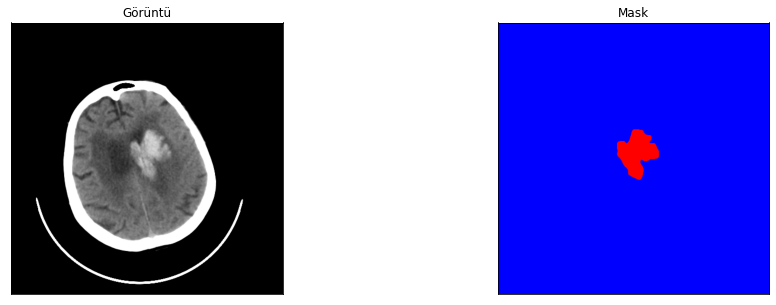

ID ./yarisma_resim/PNG/10029.png


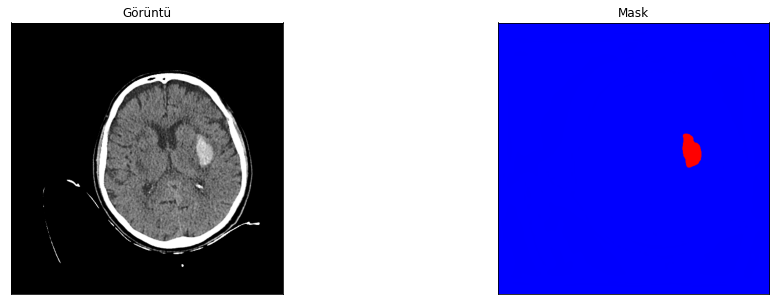

ID ./yarisma_resim/PNG/10189.png


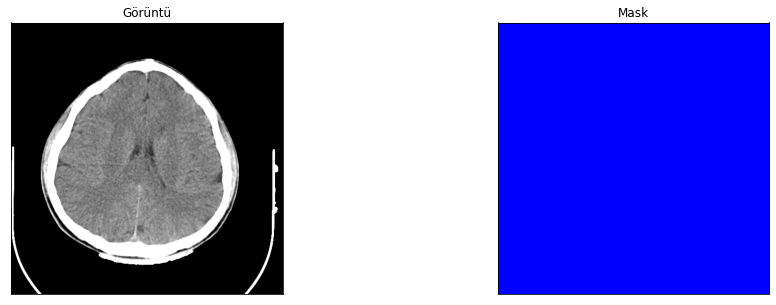

ID ./yarisma_resim/PNG/10200.png


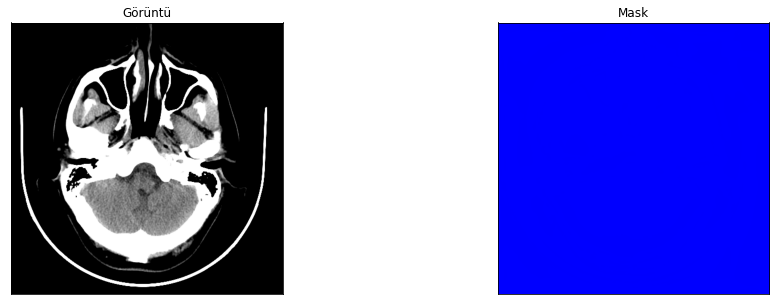

ID ./yarisma_resim/PNG/10231.png


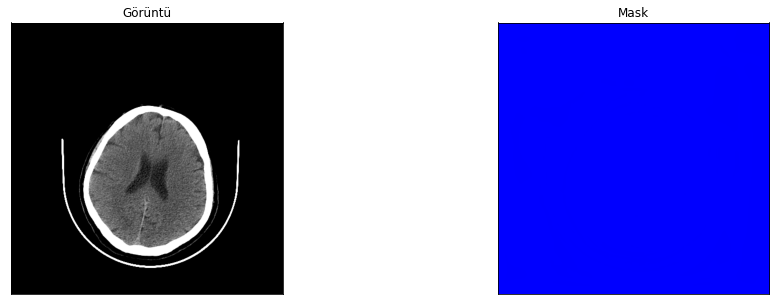

ID ./yarisma_resim/PNG/10241.png


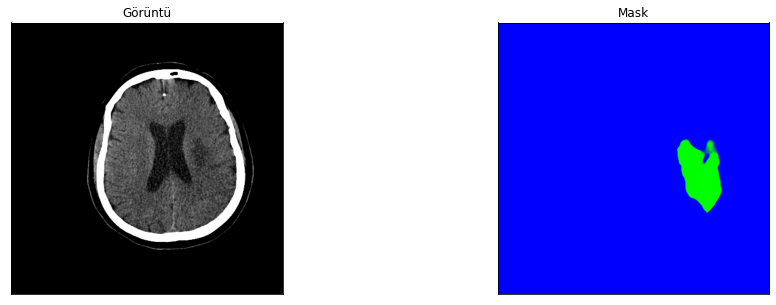

ID ./yarisma_resim/PNG/10267.png


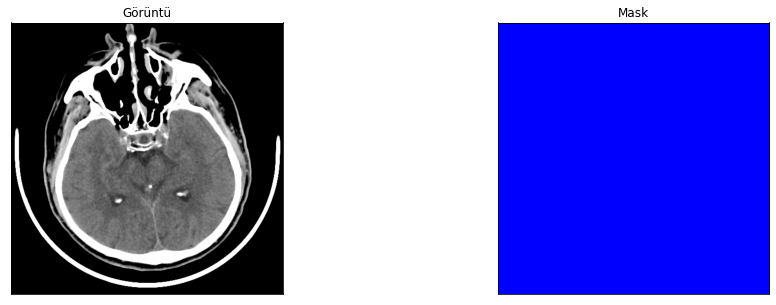

ID ./yarisma_resim/PNG/10300.png


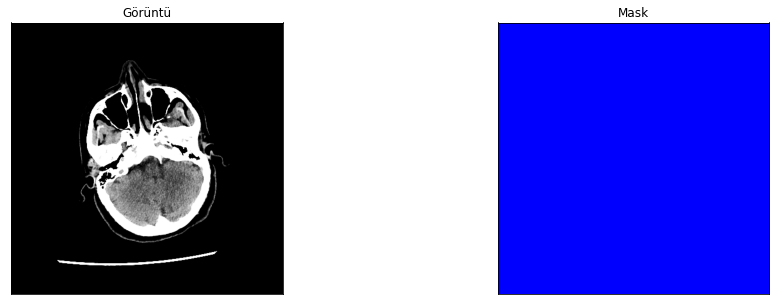

ID ./yarisma_resim/PNG/10301.png


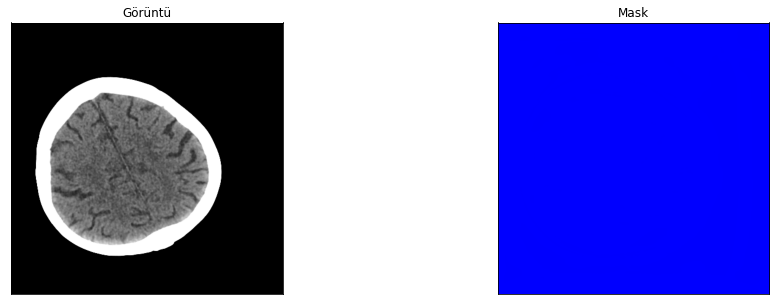

ID ./yarisma_resim/PNG/10319.png


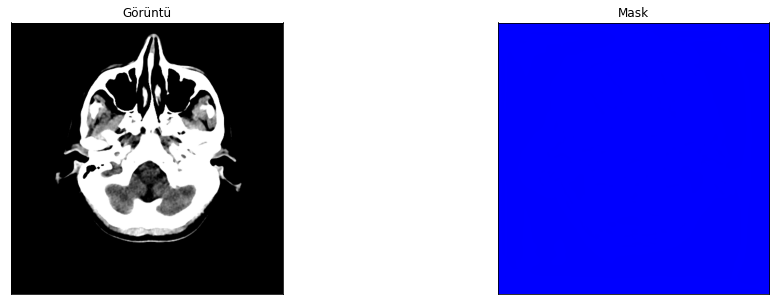

ID ./yarisma_resim/PNG/10360.png


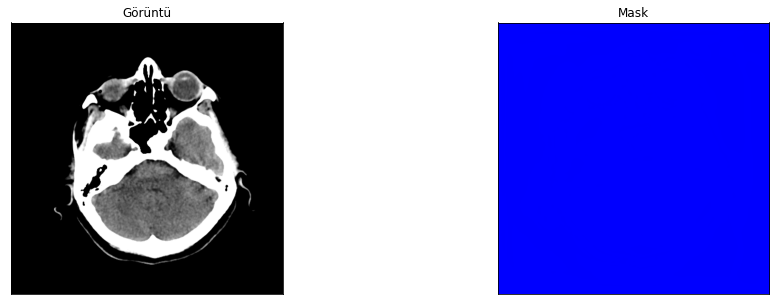

ID ./yarisma_resim/PNG/10437.png


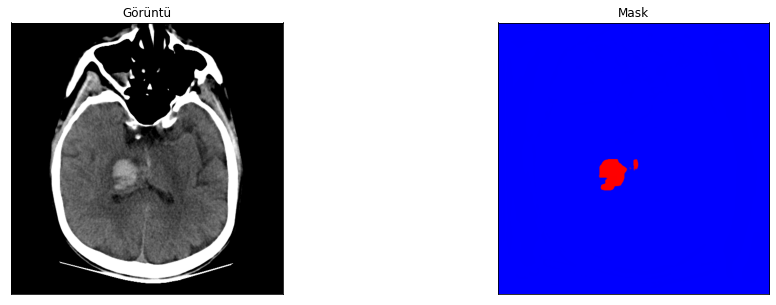

ID ./yarisma_resim/PNG/10493.png


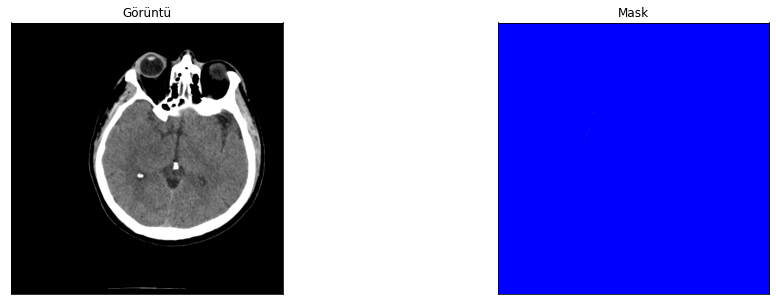

ID ./yarisma_resim/PNG/10494.png


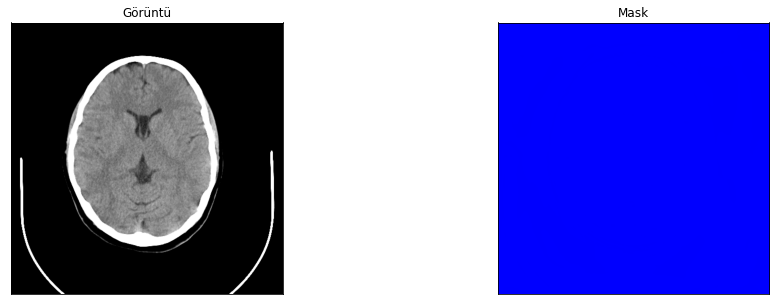

ID ./yarisma_resim/PNG/10641.png


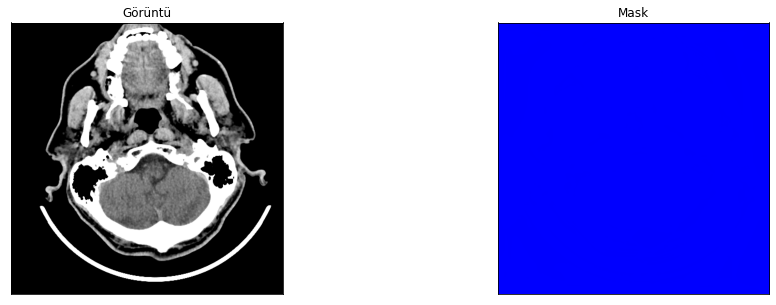

ID ./yarisma_resim/PNG/10693.png


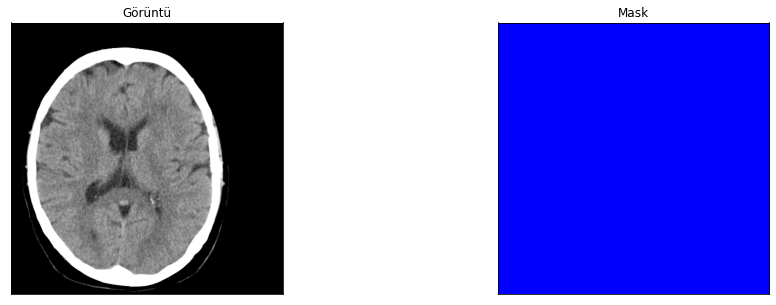

ID ./yarisma_resim/PNG/10785.png


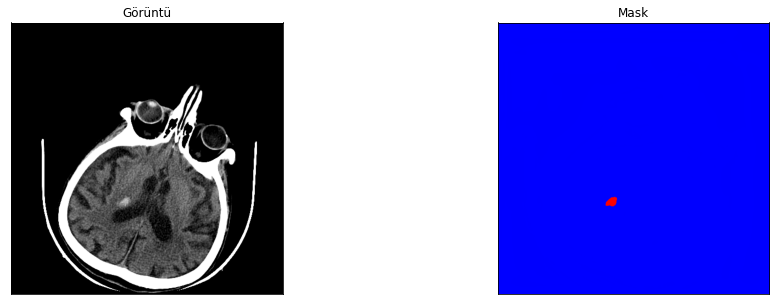

ID ./yarisma_resim/PNG/10833.png


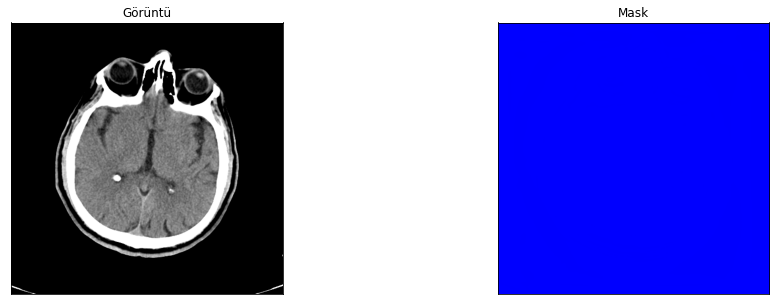

ID ./yarisma_resim/PNG/10910.png


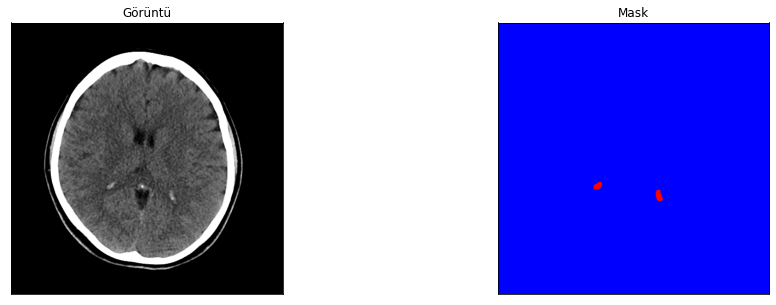

ID ./yarisma_resim/PNG/10911.png


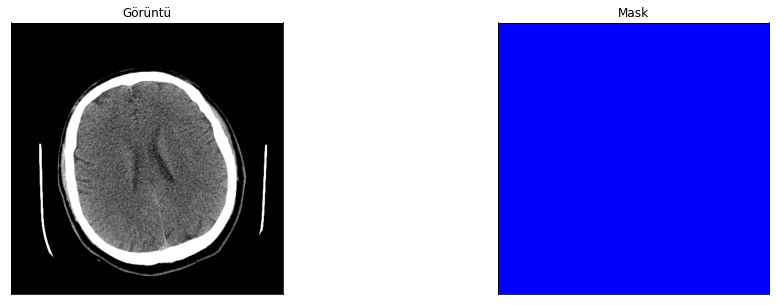

ID ./yarisma_resim/PNG/10917.png


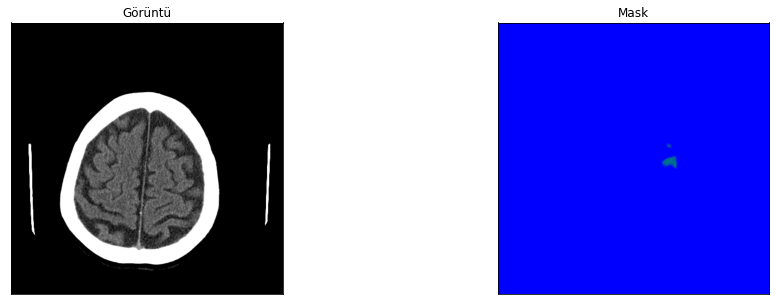

ID ./yarisma_resim/PNG/10923.png


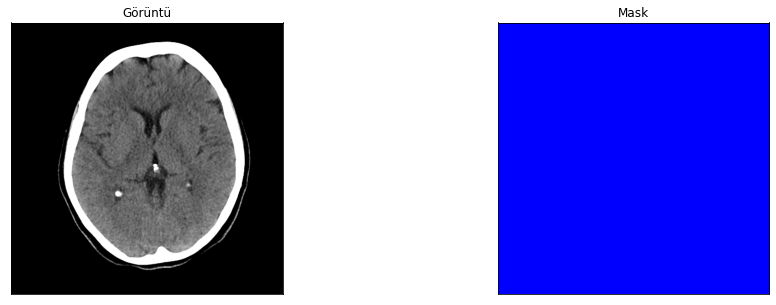

ID ./yarisma_resim/PNG/10958.png


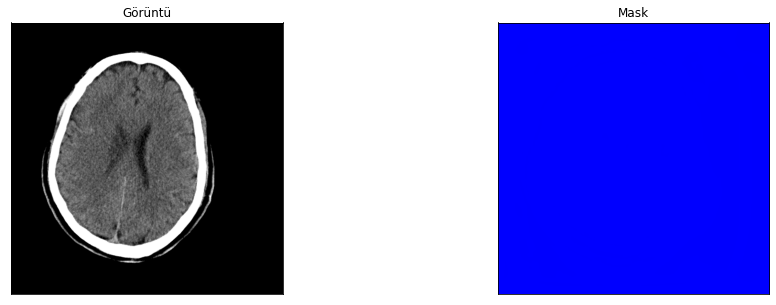

ID ./yarisma_resim/PNG/11023.png


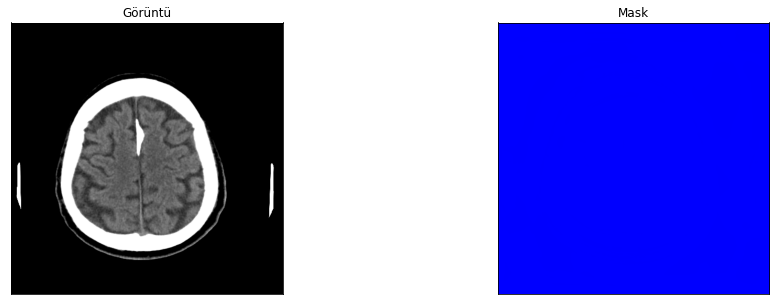

ID ./yarisma_resim/PNG/11072.png


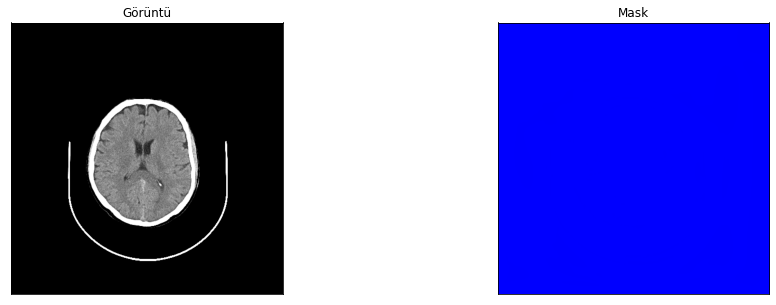

ID ./yarisma_resim/PNG/11074.png


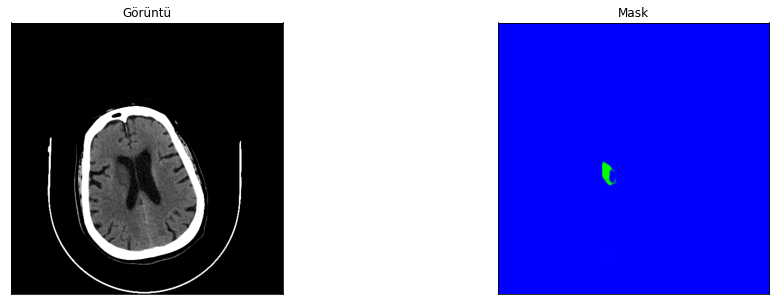

ID ./yarisma_resim/PNG/11104.png


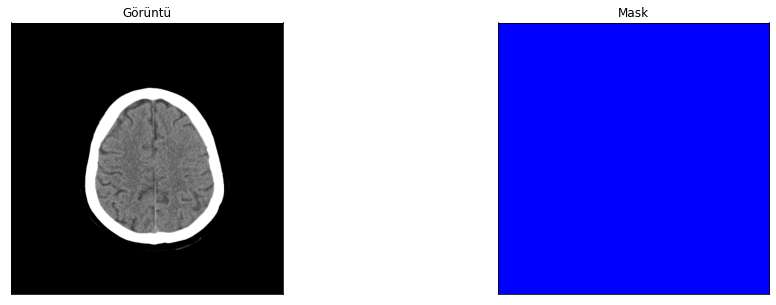

ID ./yarisma_resim/PNG/11114.png


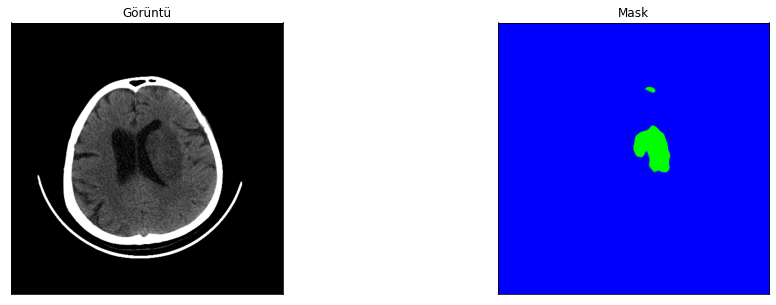

ID ./yarisma_resim/PNG/11133.png


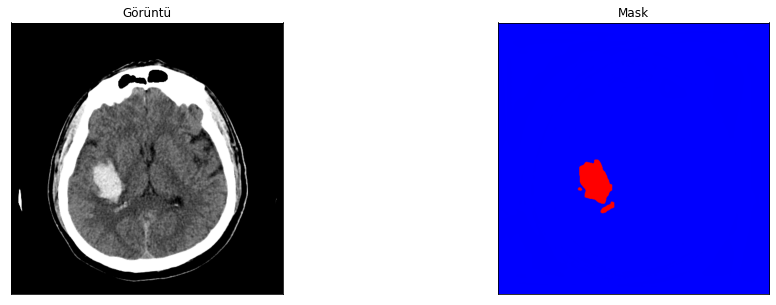

ID ./yarisma_resim/PNG/11263.png


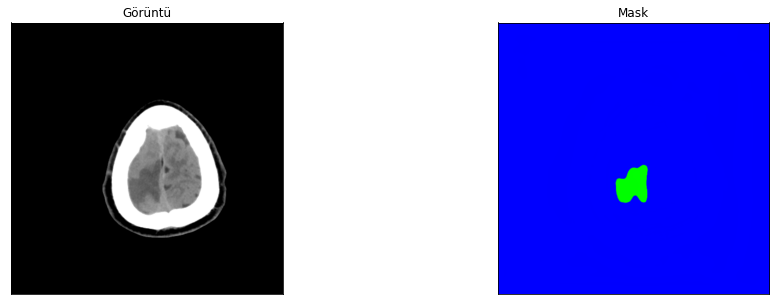

ID ./yarisma_resim/PNG/11308.png


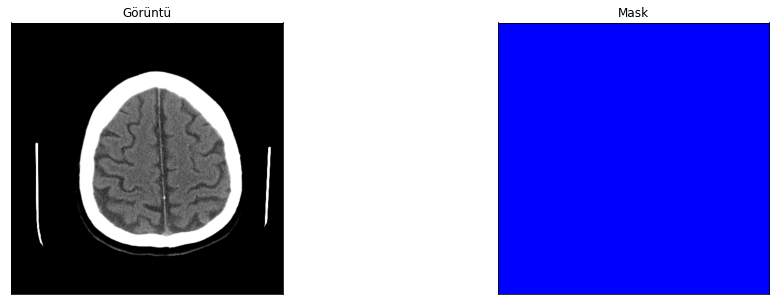

ID ./yarisma_resim/PNG/11318.png


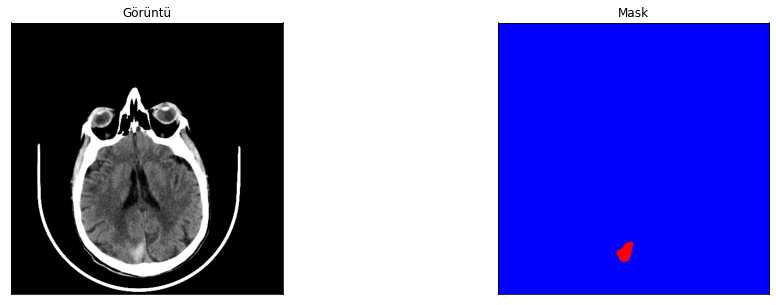

ID ./yarisma_resim/PNG/11319.png


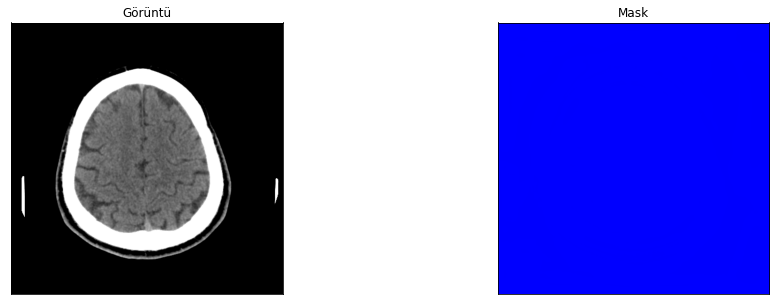

ID ./yarisma_resim/PNG/11336.png


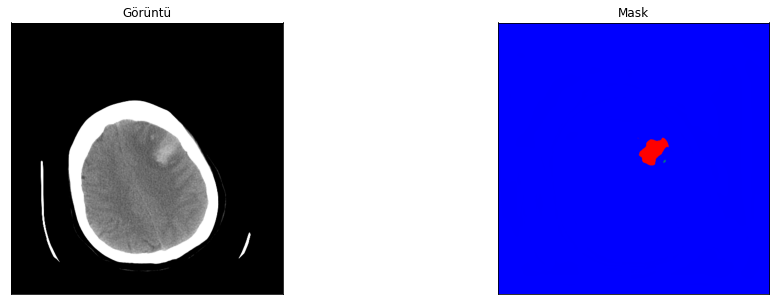

ID ./yarisma_resim/PNG/11465.png


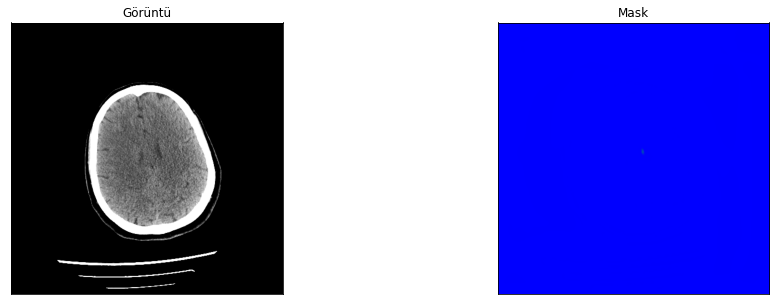

ID ./yarisma_resim/PNG/11479.png


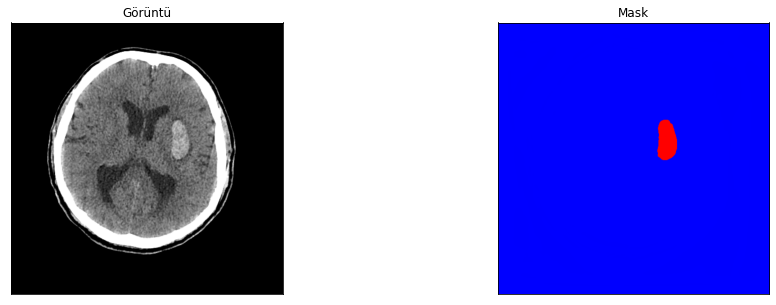

ID ./yarisma_resim/PNG/11482.png


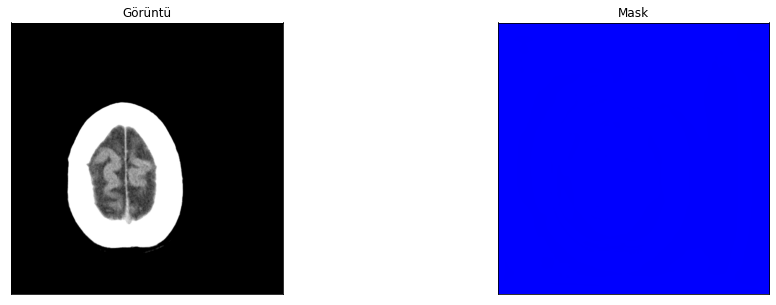

ID ./yarisma_resim/PNG/11520.png


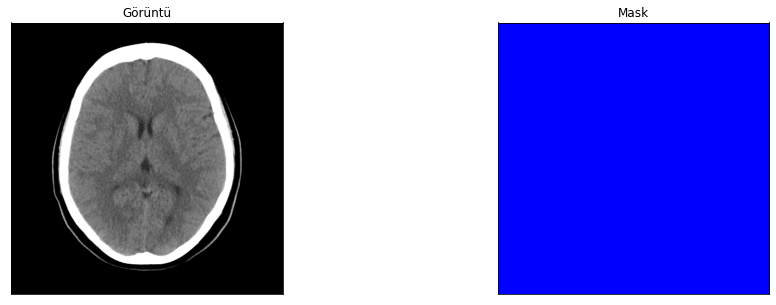

ID ./yarisma_resim/PNG/11530.png


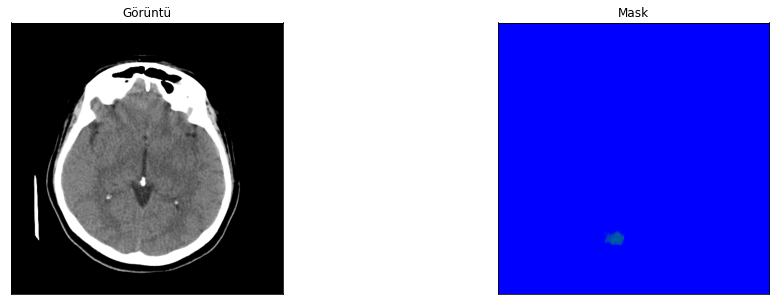

ID ./yarisma_resim/PNG/11563.png


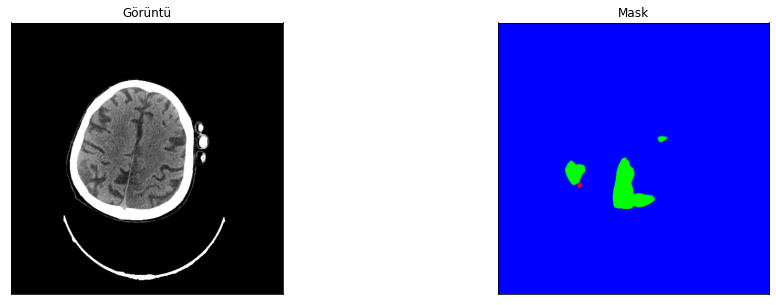

ID ./yarisma_resim/PNG/11564.png


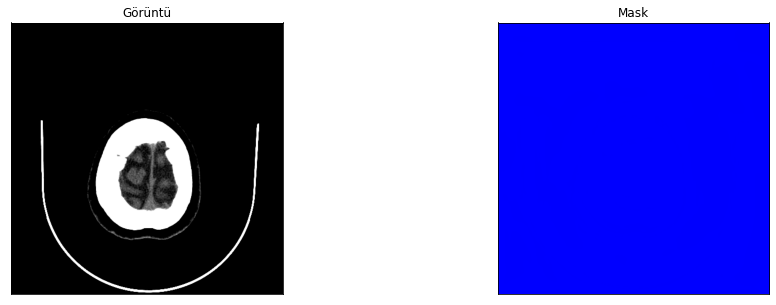

ID ./yarisma_resim/PNG/11612.png


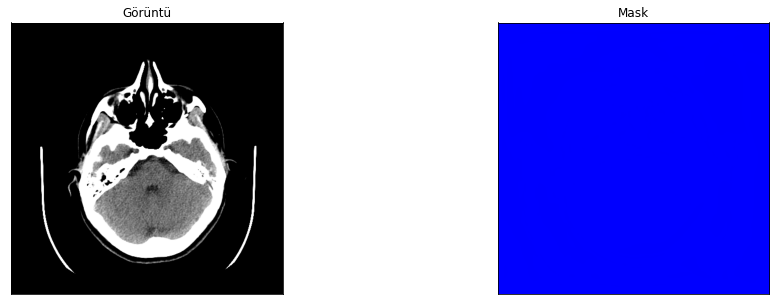

ID ./yarisma_resim/PNG/11619.png


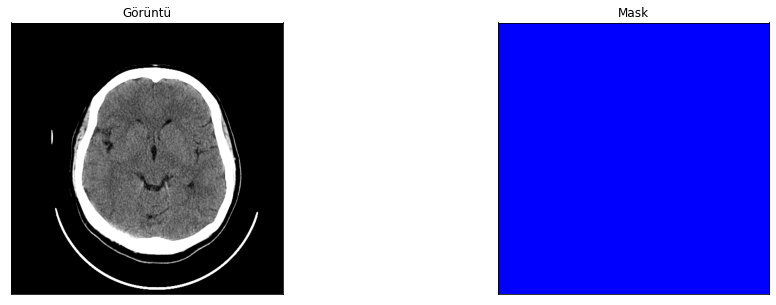

ID ./yarisma_resim/PNG/11651.png


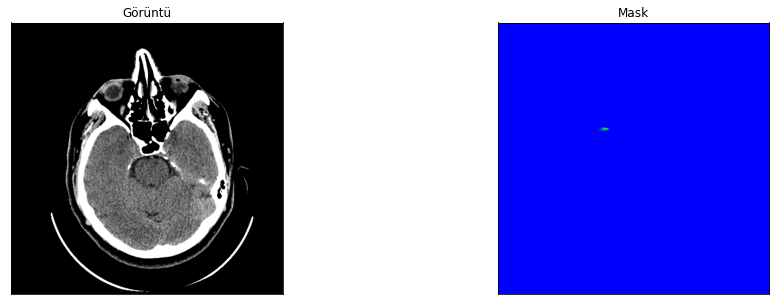

ID ./yarisma_resim/PNG/11669.png


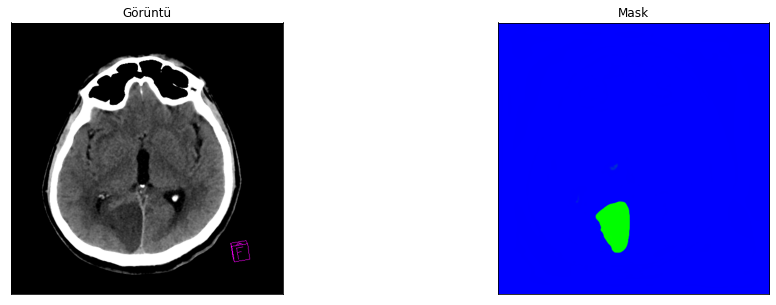

ID ./yarisma_resim/PNG/11800.png


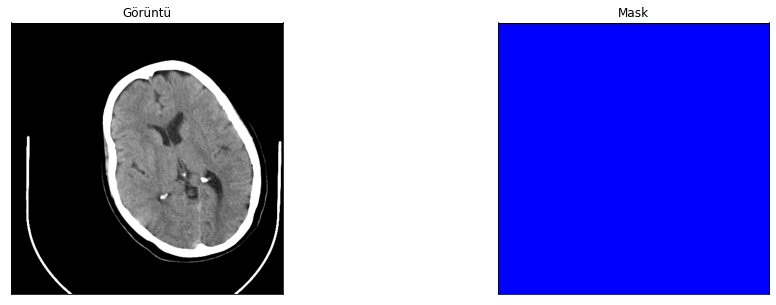

ID ./yarisma_resim/PNG/11864.png


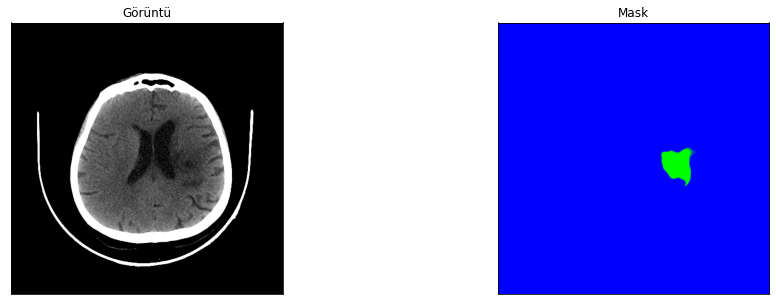

ID ./yarisma_resim/PNG/11925.png


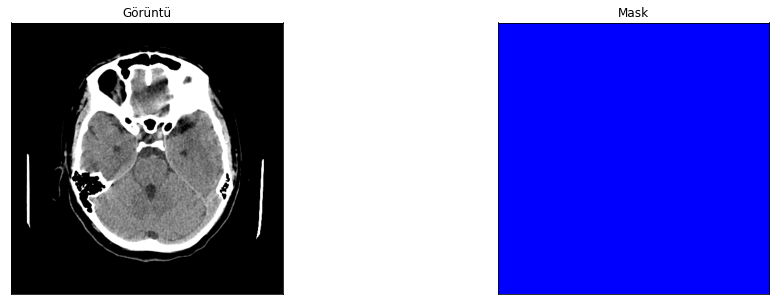

ID ./yarisma_resim/PNG/11963.png


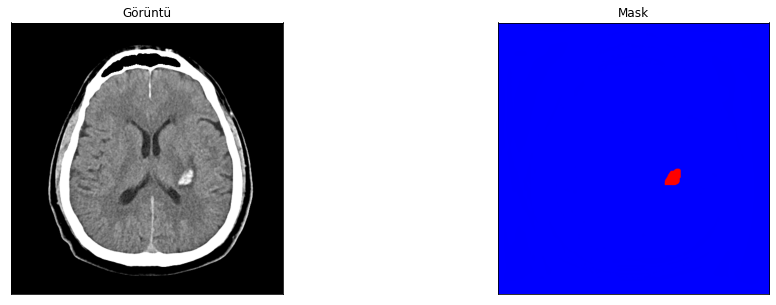

ID ./yarisma_resim/PNG/11964.png


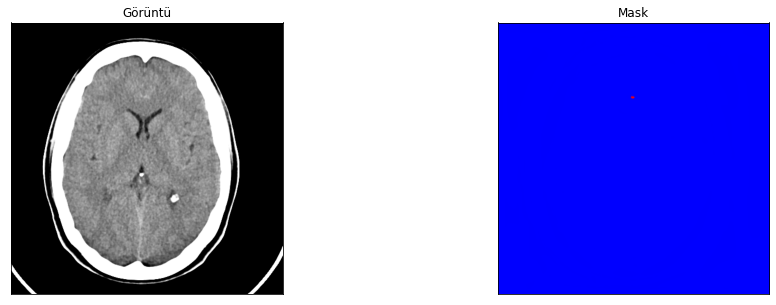

ID ./yarisma_resim/PNG/11965.png


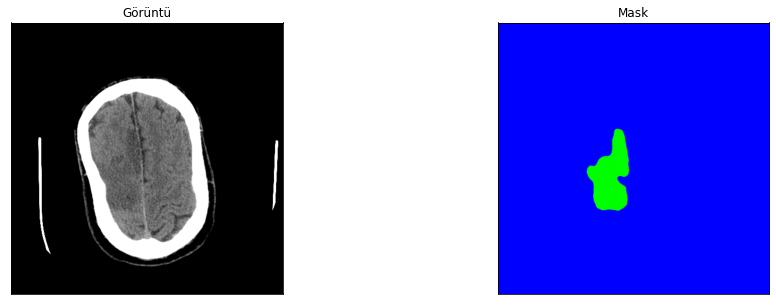

ID ./yarisma_resim/PNG/11966.png


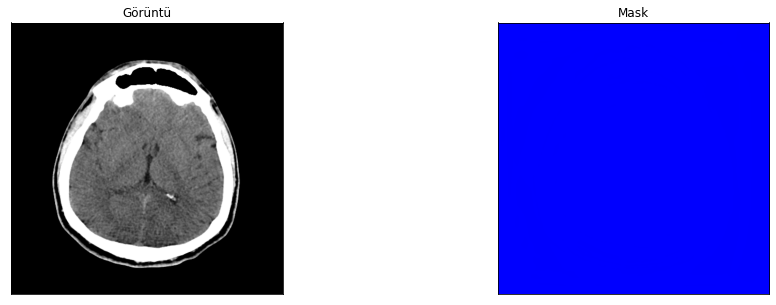

ID ./yarisma_resim/PNG/12009.png


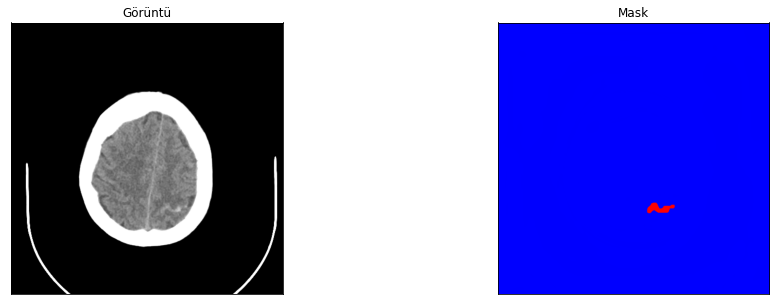

ID ./yarisma_resim/PNG/12018.png


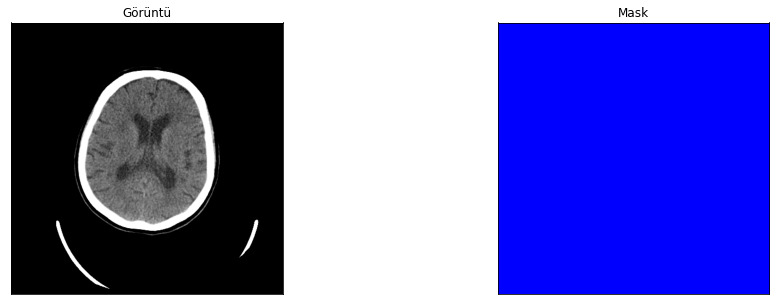

ID ./yarisma_resim/PNG/12079.png


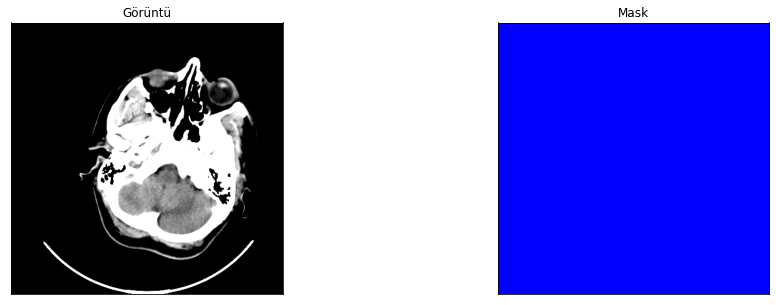

ID ./yarisma_resim/PNG/12199.png


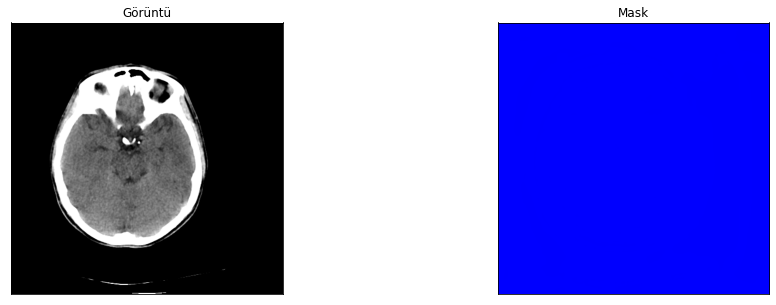

ID ./yarisma_resim/PNG/12289.png


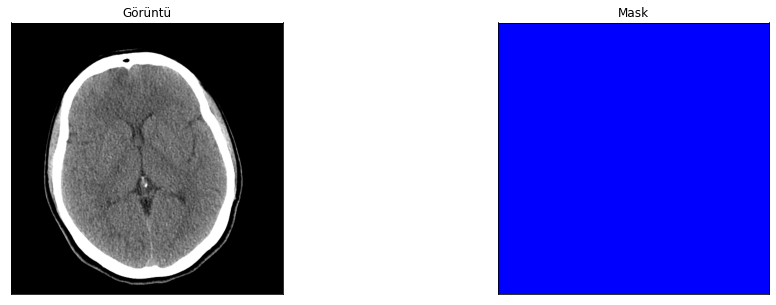

ID ./yarisma_resim/PNG/12344.png


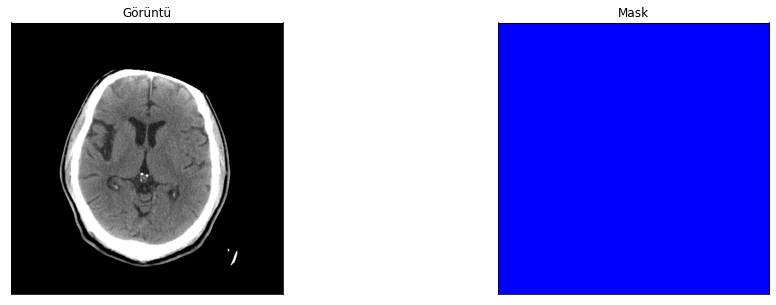

ID ./yarisma_resim/PNG/12383.png


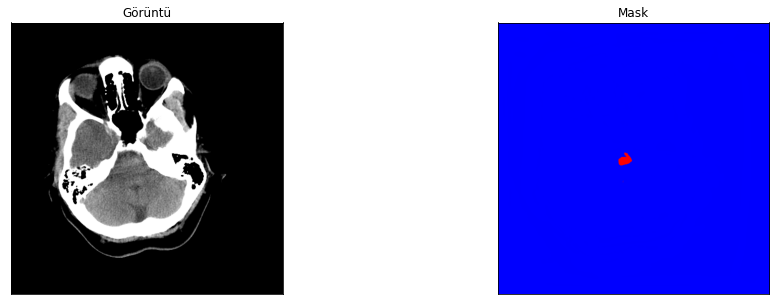

ID ./yarisma_resim/PNG/12487.png


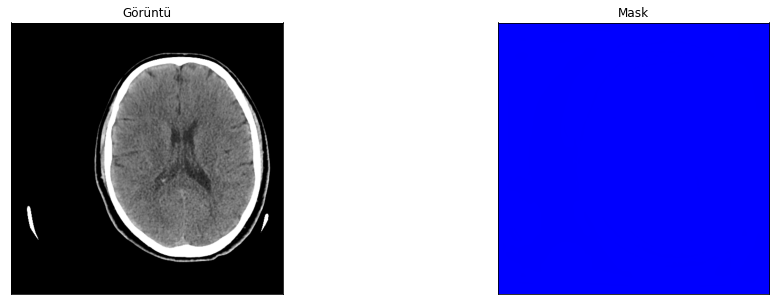

ID ./yarisma_resim/PNG/12488.png


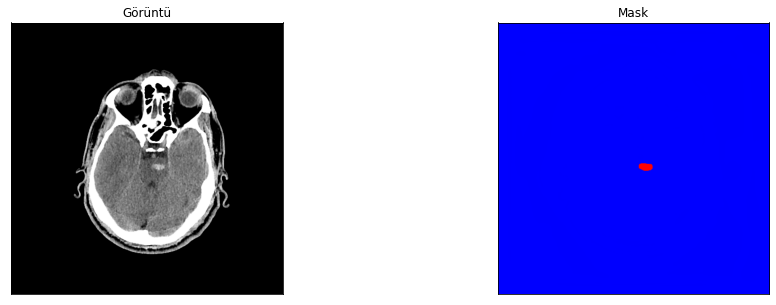

ID ./yarisma_resim/PNG/12542.png


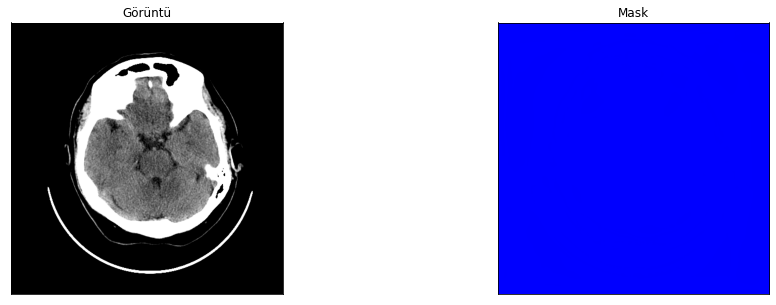

ID ./yarisma_resim/PNG/12593.png


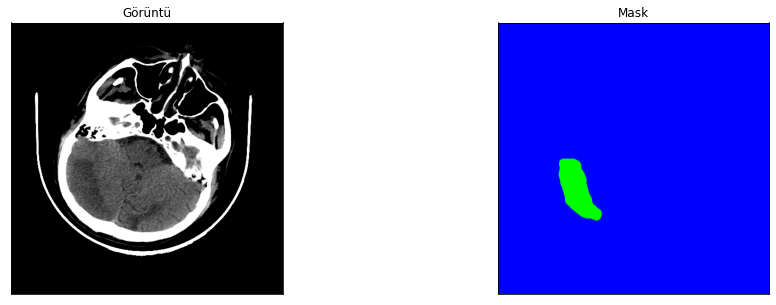

ID ./yarisma_resim/PNG/12603.png


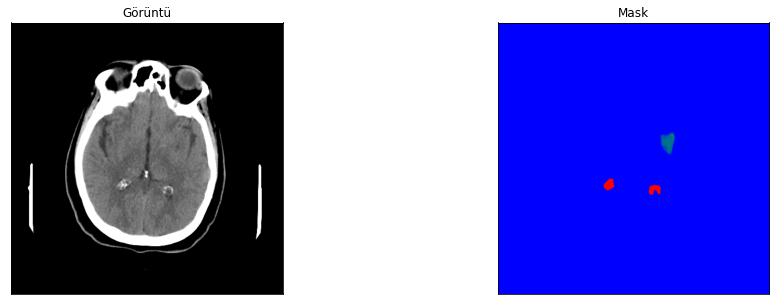

ID ./yarisma_resim/PNG/12616.png


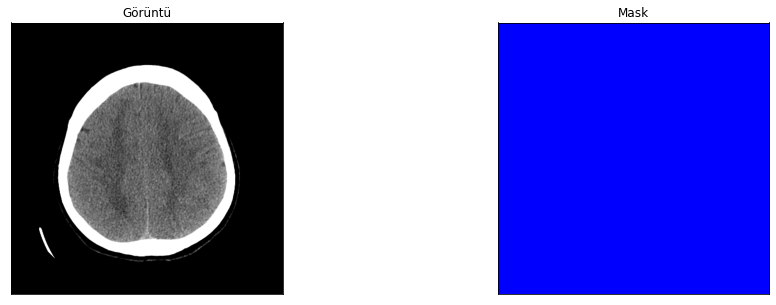

ID ./yarisma_resim/PNG/12639.png


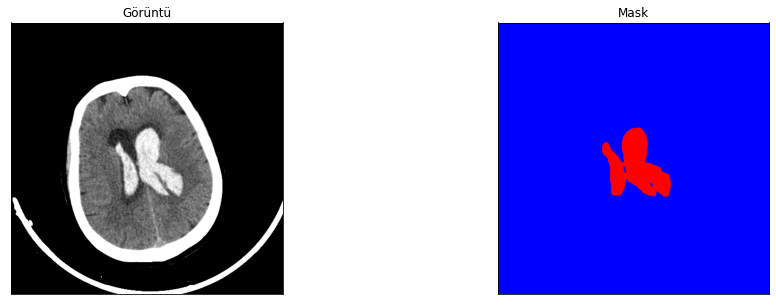

ID ./yarisma_resim/PNG/12645.png


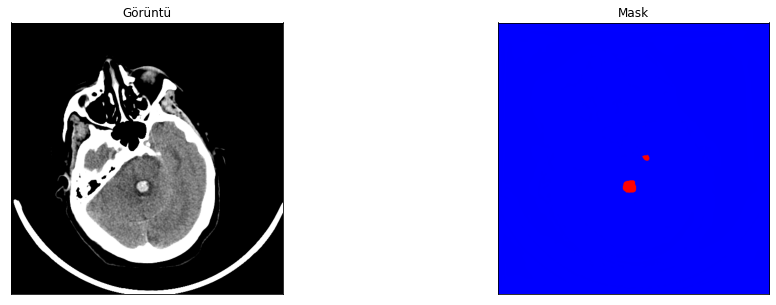

ID ./yarisma_resim/PNG/12743.png


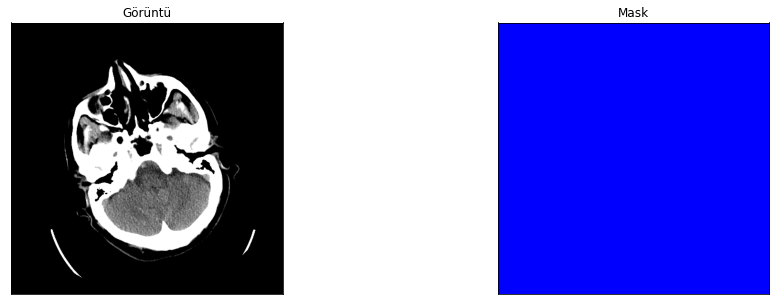

ID ./yarisma_resim/PNG/12918.png


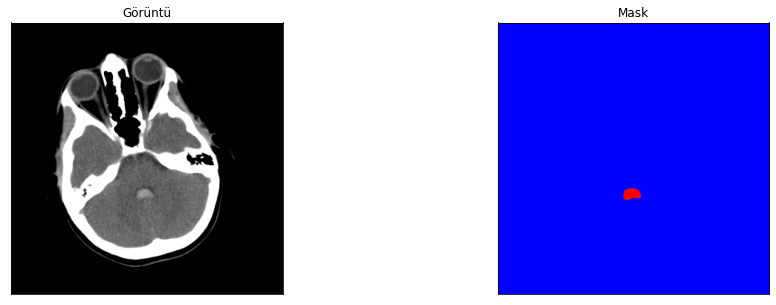

ID ./yarisma_resim/PNG/12933.png


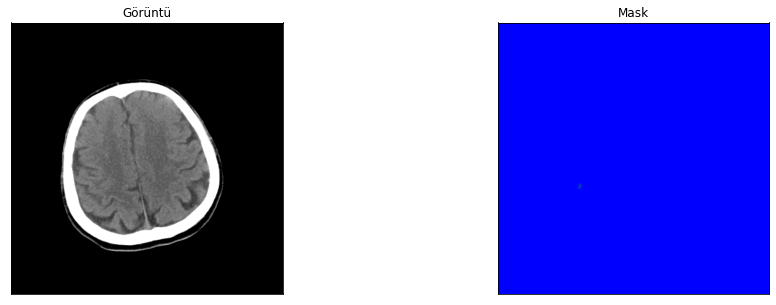

ID ./yarisma_resim/PNG/12996.png


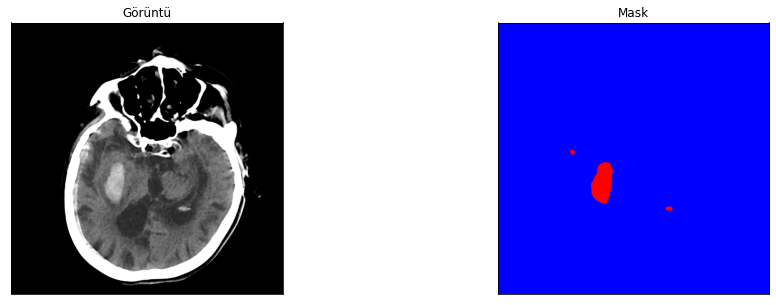

ID ./yarisma_resim/PNG/12997.png


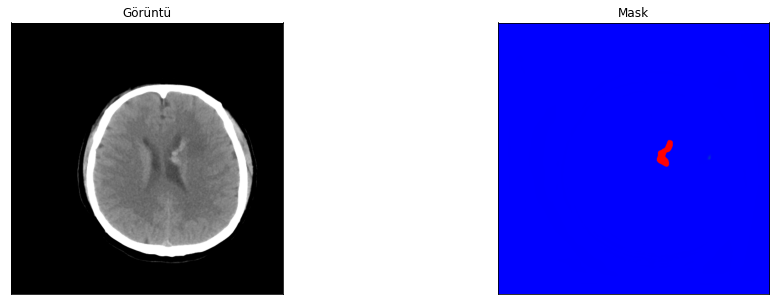

ID ./yarisma_resim/PNG/13021.png


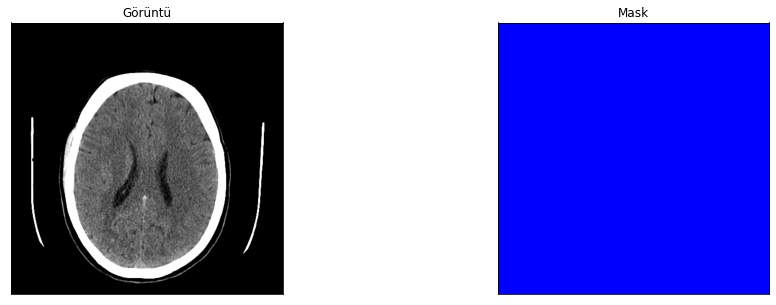

ID ./yarisma_resim/PNG/13051.png


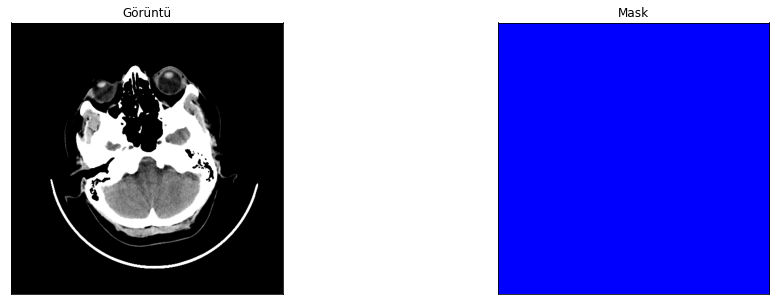

ID ./yarisma_resim/PNG/13063.png


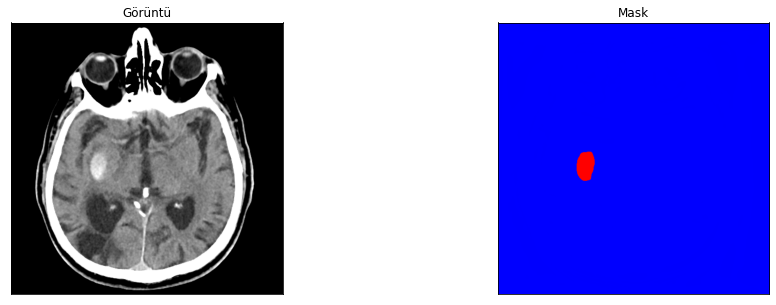

ID ./yarisma_resim/PNG/13065.png


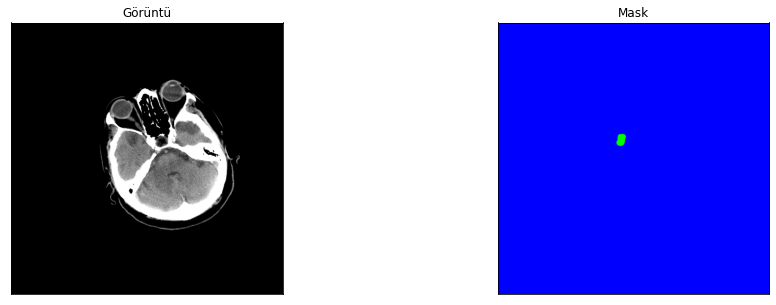

ID ./yarisma_resim/PNG/13087.png


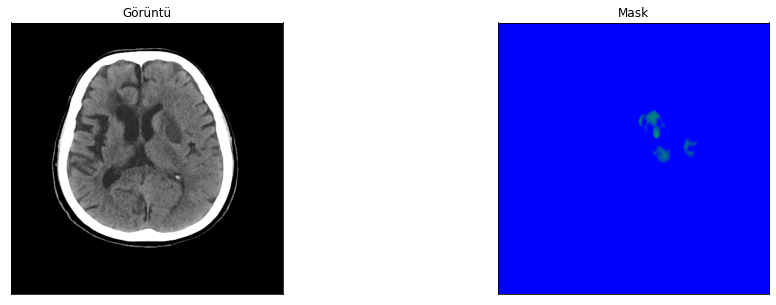

ID ./yarisma_resim/PNG/13137.png


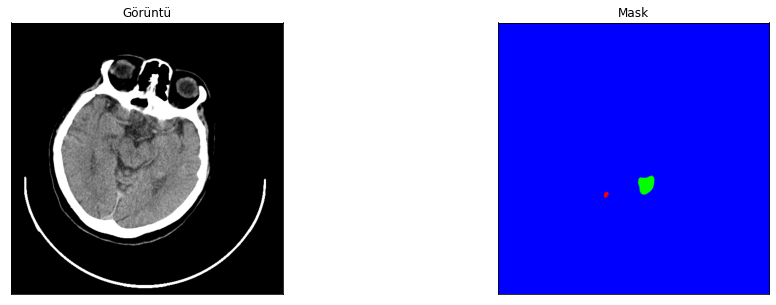

ID ./yarisma_resim/PNG/13179.png


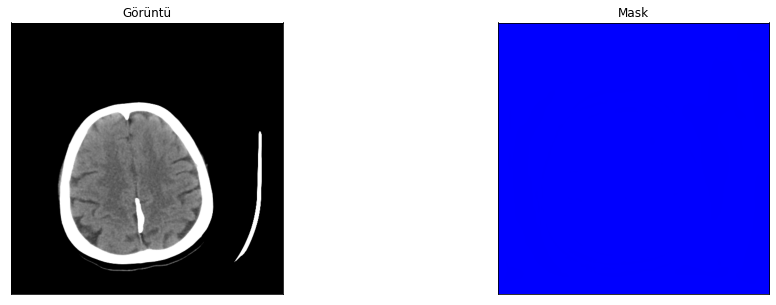

ID ./yarisma_resim/PNG/13239.png


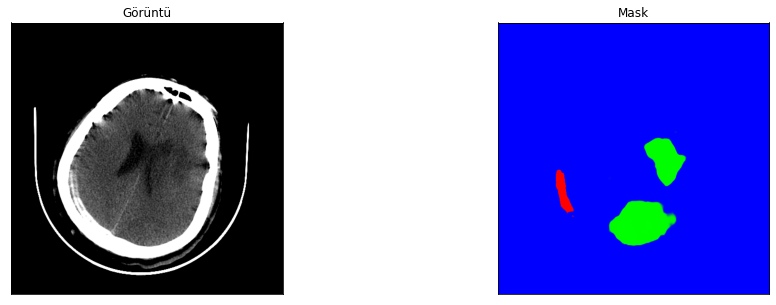

ID ./yarisma_resim/PNG/13241.png


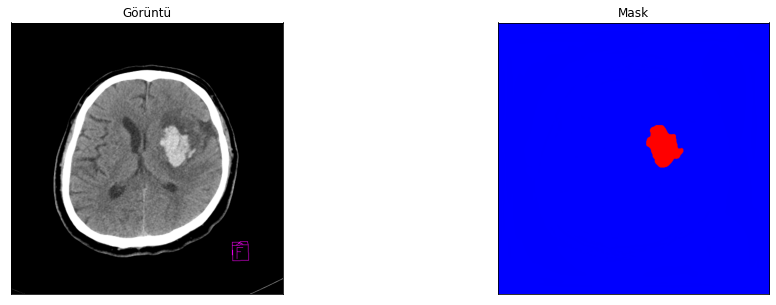

ID ./yarisma_resim/PNG/13345.png


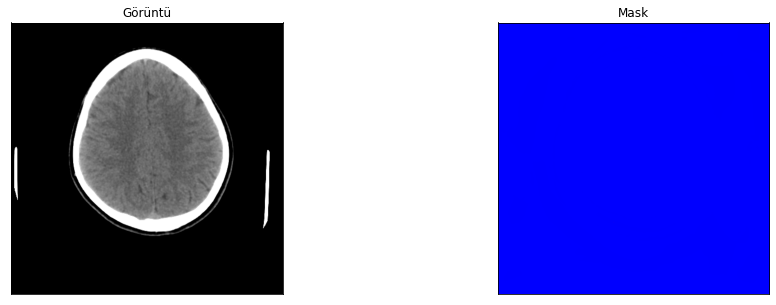

ID ./yarisma_resim/PNG/13446.png


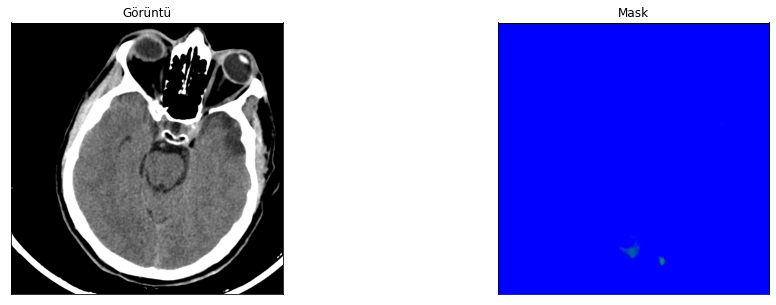

ID ./yarisma_resim/PNG/13447.png


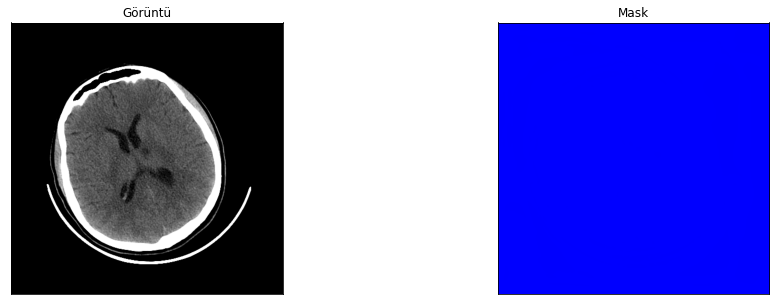

ID ./yarisma_resim/PNG/13459.png


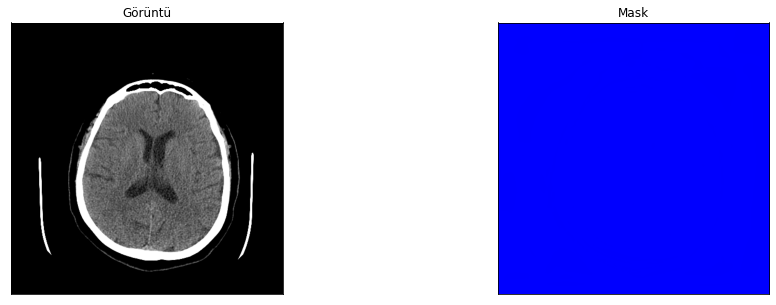

ID ./yarisma_resim/PNG/13477.png


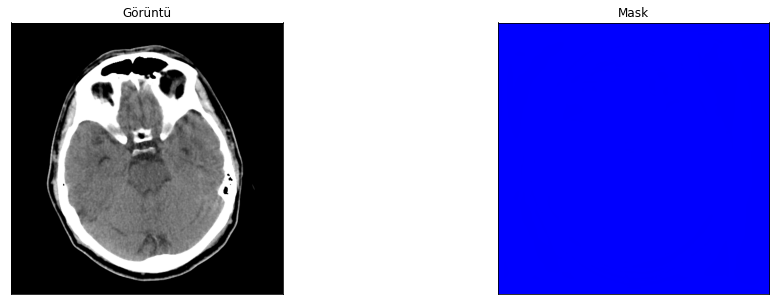

ID ./yarisma_resim/PNG/13497.png


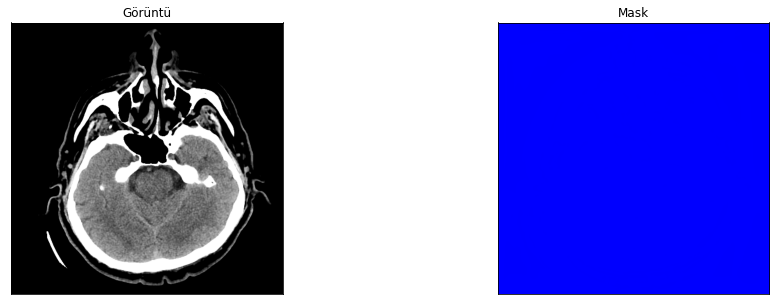

ID ./yarisma_resim/PNG/13554.png


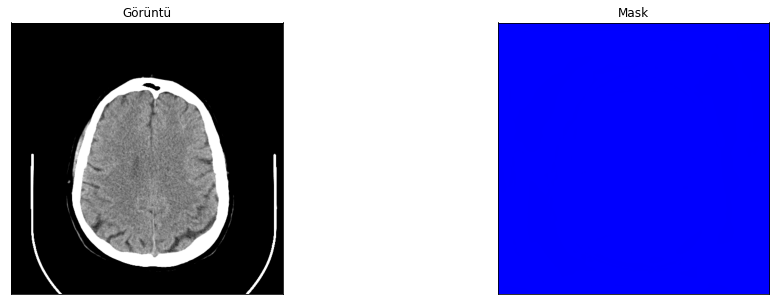

ID ./yarisma_resim/PNG/13579.png


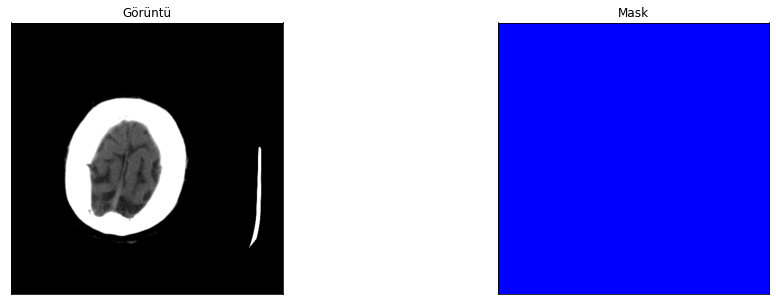

ID ./yarisma_resim/PNG/13597.png


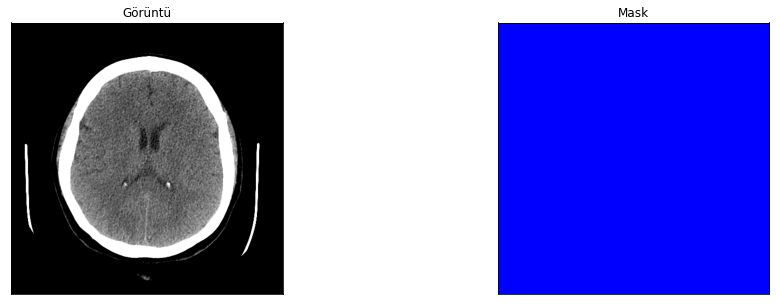

ID ./yarisma_resim/PNG/13600.png


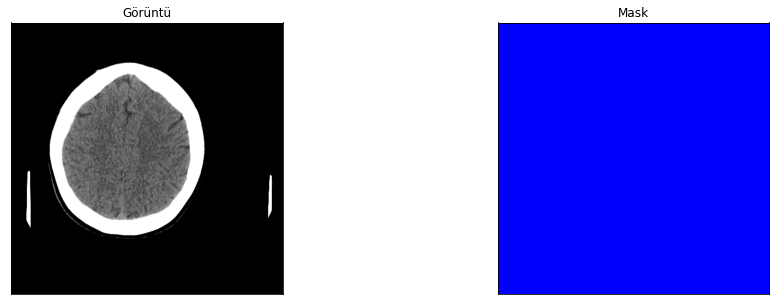

ID ./yarisma_resim/PNG/13680.png


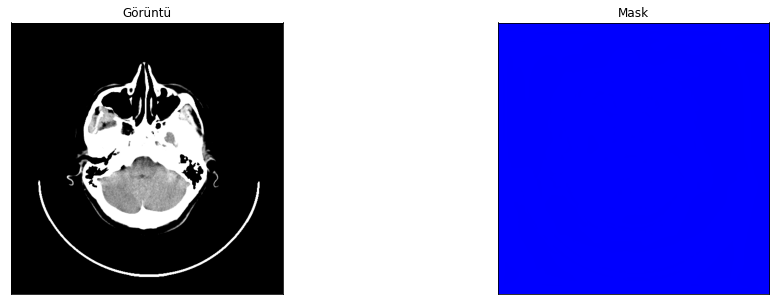

ID ./yarisma_resim/PNG/13708.png


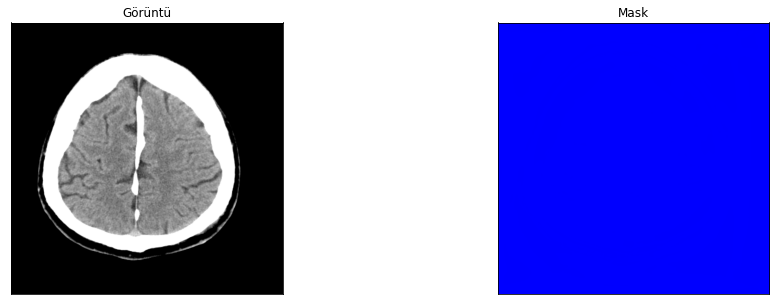

ID ./yarisma_resim/PNG/13713.png


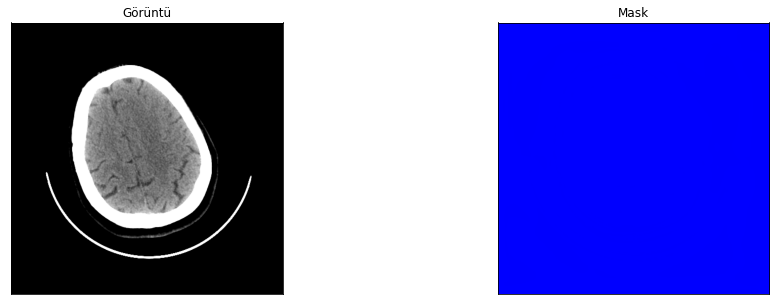

ID ./yarisma_resim/PNG/13729.png


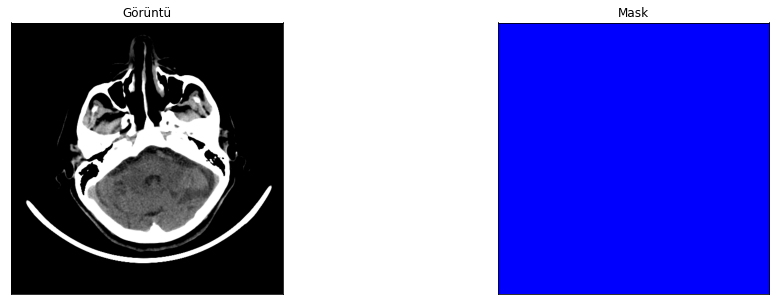

ID ./yarisma_resim/PNG/13731.png


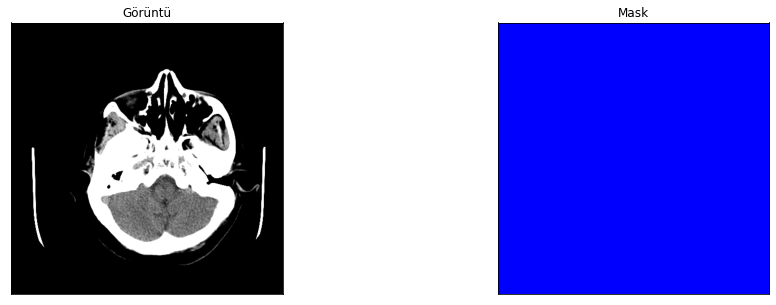

ID ./yarisma_resim/PNG/13747.png


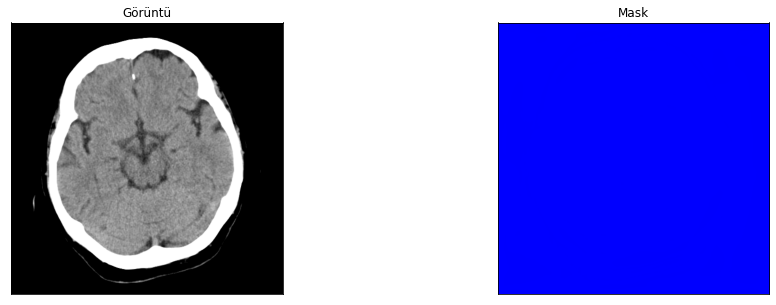

ID ./yarisma_resim/PNG/13769.png


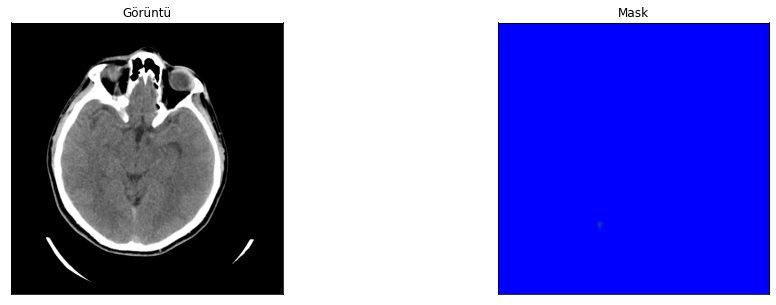

ID ./yarisma_resim/PNG/13770.png


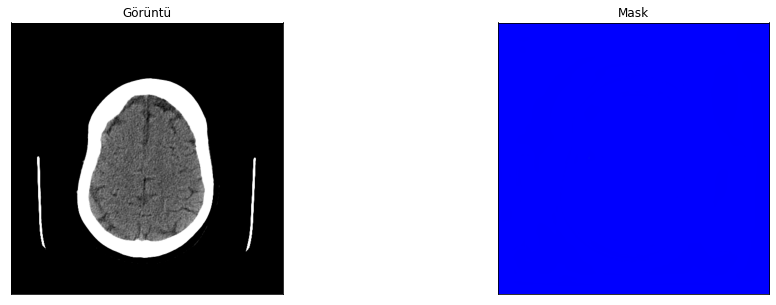

ID ./yarisma_resim/PNG/13887.png


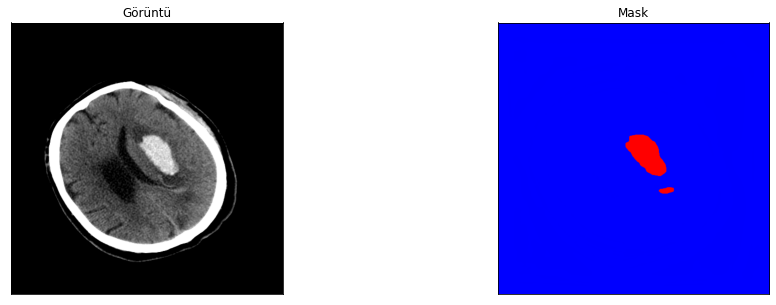

ID ./yarisma_resim/PNG/13893.png


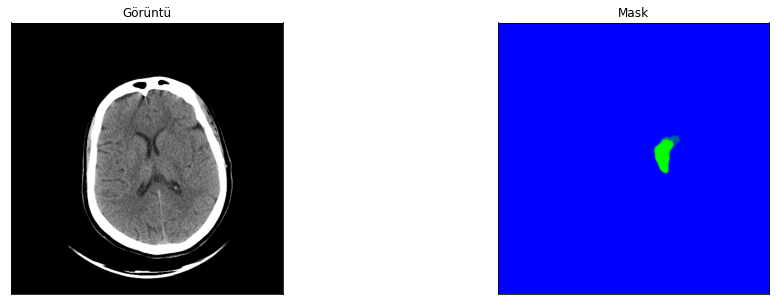

ID ./yarisma_resim/PNG/13896.png


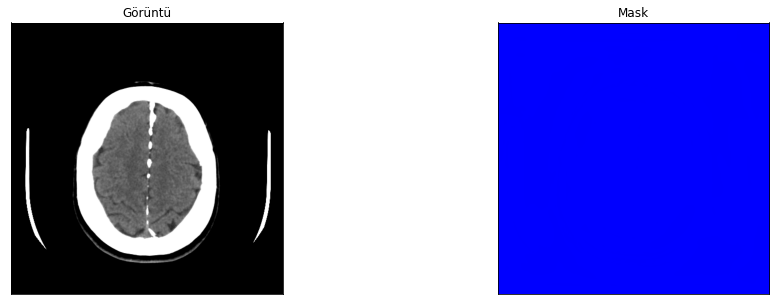

ID ./yarisma_resim/PNG/14031.png


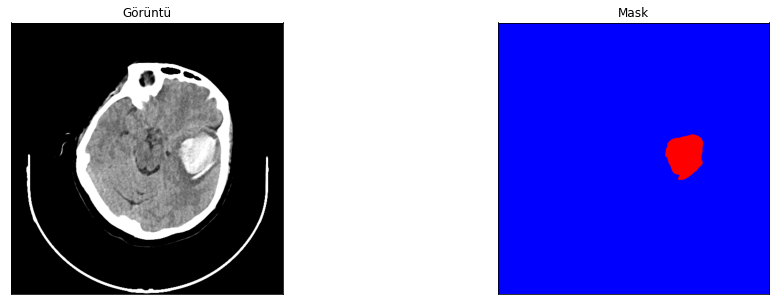

ID ./yarisma_resim/PNG/14101.png


InvalidArgumentError:  ConcatOp : Dimensions of inputs should match: shape[0] = [1,1536,38,32] vs. shape[1] = [1,816,37,32]
	 [[node model/decoder_stage0_concat/concat (defined at tmp/ipykernel_71648/2181849892.py:26) ]] [Op:__inference_predict_function_33126]

Errors may have originated from an input operation.
Input Source operations connected to node model/decoder_stage0_concat/concat:
 model/block6a_expand_activation/mul (defined at home/raistlin/Desktop/Coding/teknofest-venv/lib/python3.9/site-packages/efficientnet/model.py:115)

Function call stack:
predict_function


In [19]:
predict_filenames = tf.io.gfile.glob(f"{test_dir}*.{IMG_EXT}")
predict_filenames = sorted(predict_filenames)

for i in predict_filenames:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(f"ID {i}")
    process_img=None
    #gt_mask = cv2.imread(i.replace(test_dir, './data/dataset1/label/'), 0)
    
    # extract certain classes from mask (e.g. cars)
    #gt_masks = [(gt_mask == v) for v in [1, 2]]
    #gt_mask = np.stack(gt_masks, axis=-1).astype('float32')
    
    # add background if mask is not binary
    #if gt_mask.shape[-1] != 1:
    #    background = 1 - gt_mask.sum(axis=-1, keepdims=True)
    #    gt_mask = np.concatenate((gt_mask, background), axis=-1)

    if MODEL_PRE_TYPE == "sm":
        process_img = preprocessing_fn_sm(img)
    elif MODEL_PRE_TYPE == "custom":
        process_img = preprocessing_fn_custom(img)
    process_img = np.expand_dims(process_img, axis=0)
    
    pred_mask = model.predict(process_img)

    visualize(
    Görüntü=img.squeeze(),
    Mask=pred_mask.squeeze()
    )
    pred_mask = K.argmax(pred_mask, axis=-1)
    pred_mask += 1
    pred_mask = tf.where(tf.equal(pred_mask, 3), tf.zeros_like(pred_mask), pred_mask)
    cv2.imwrite(i.replace(test_dir, save_dir), pred_mask.numpy().squeeze())

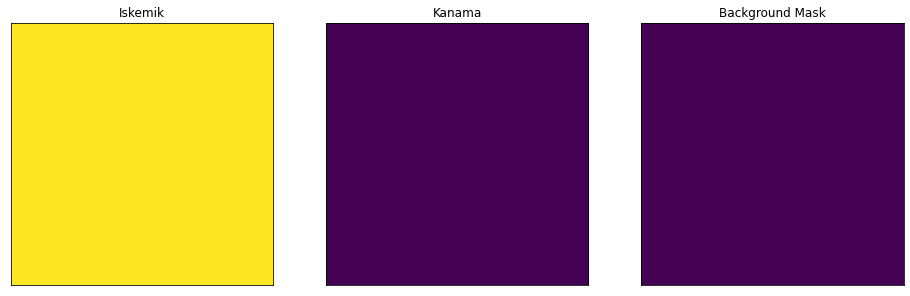

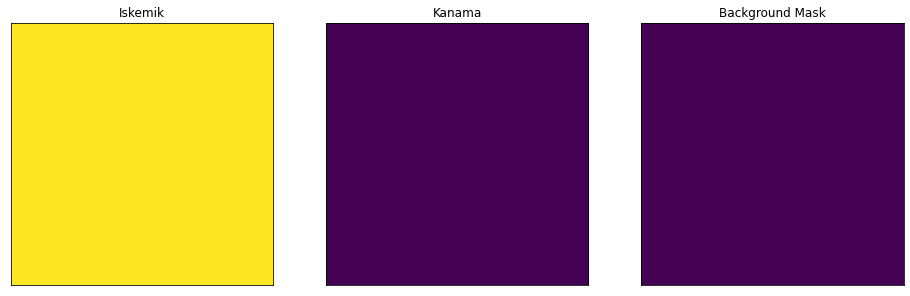

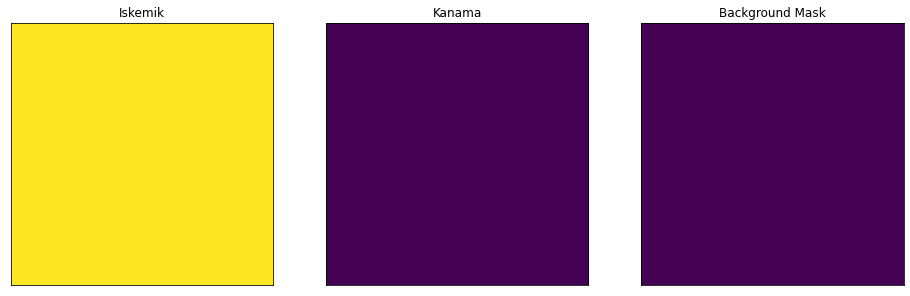

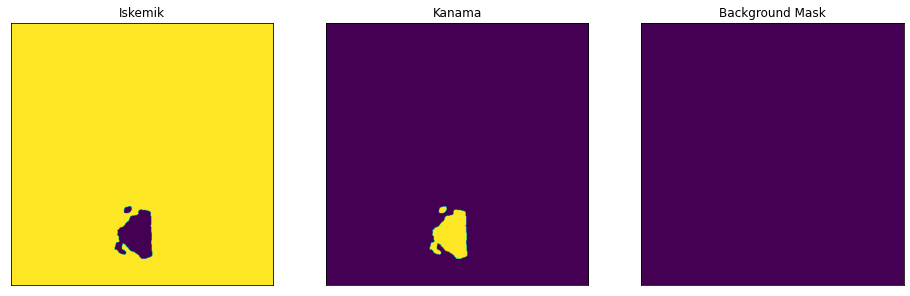

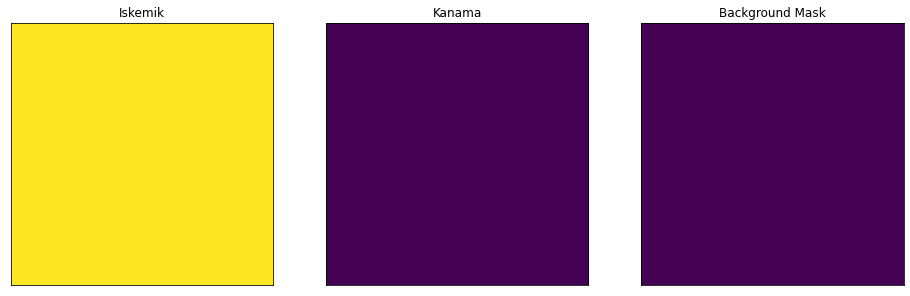

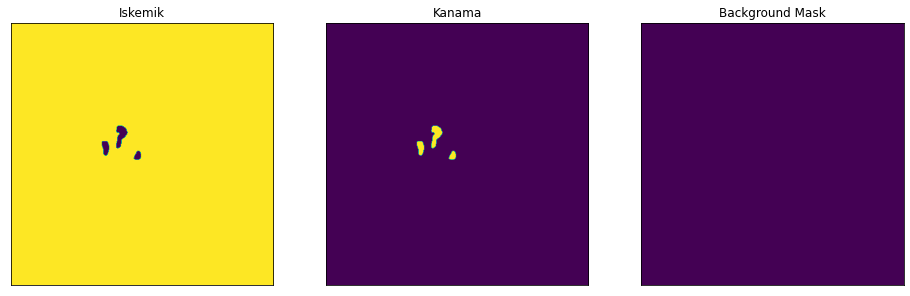

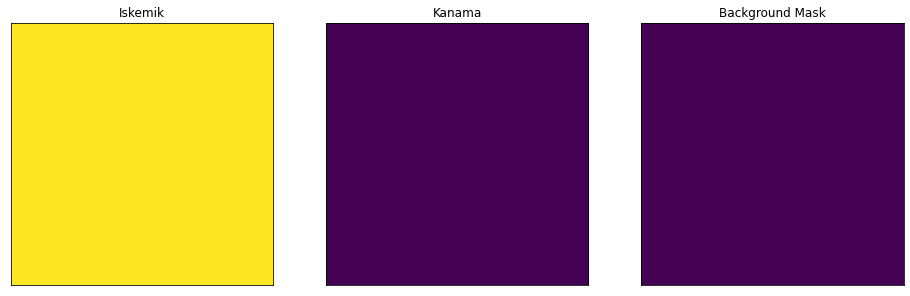

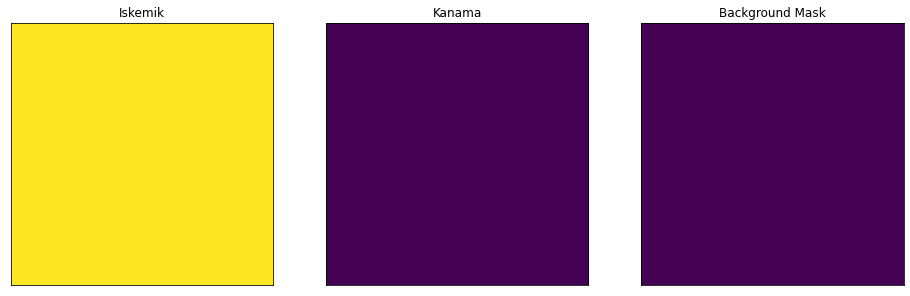

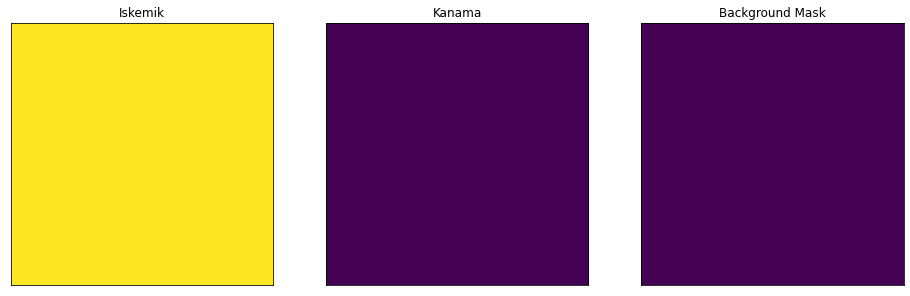

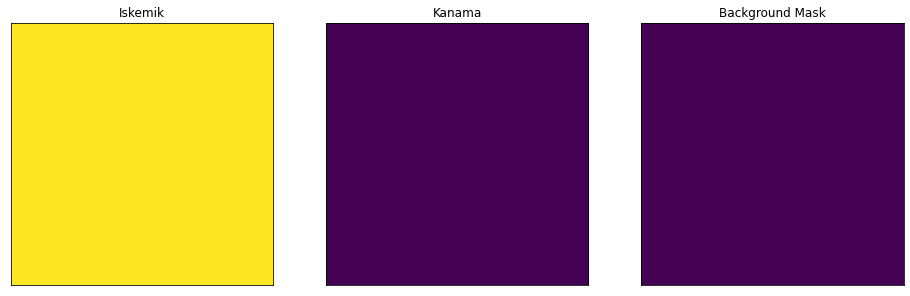

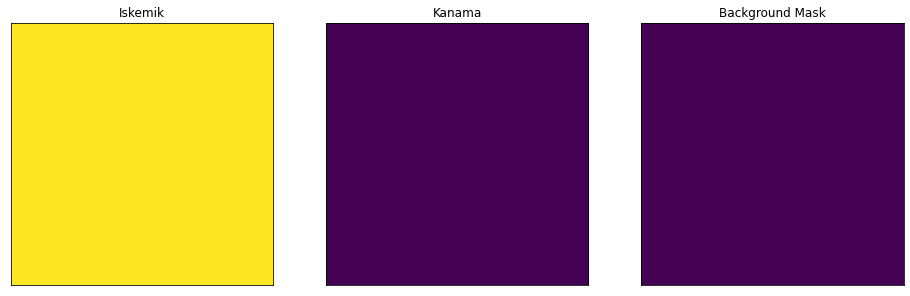

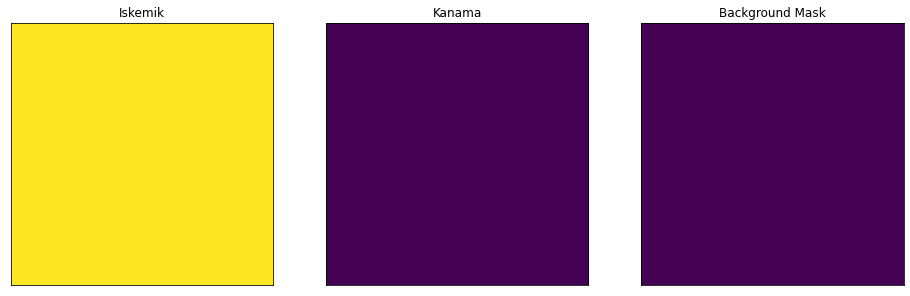

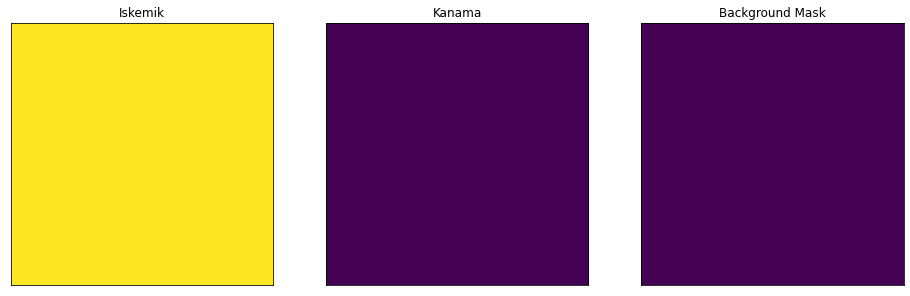

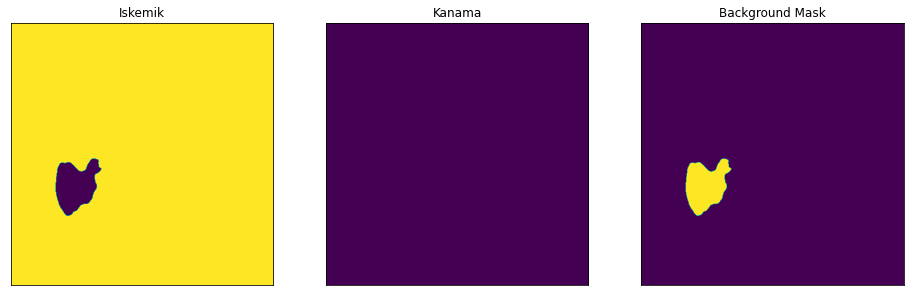

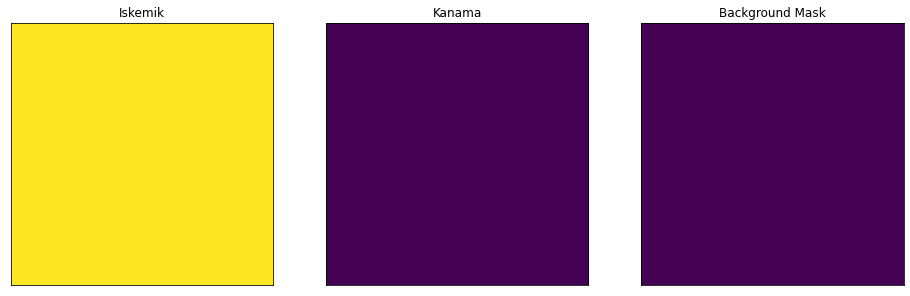

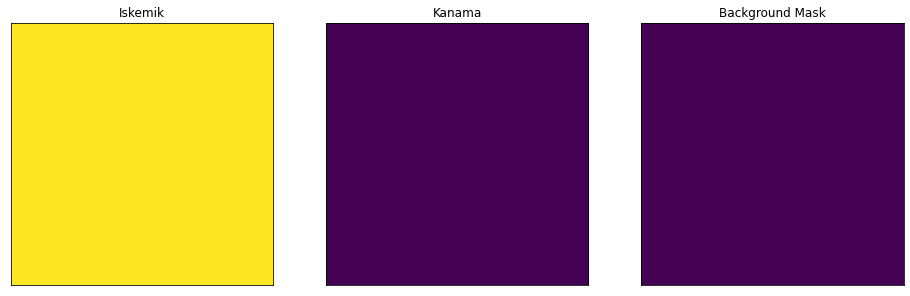

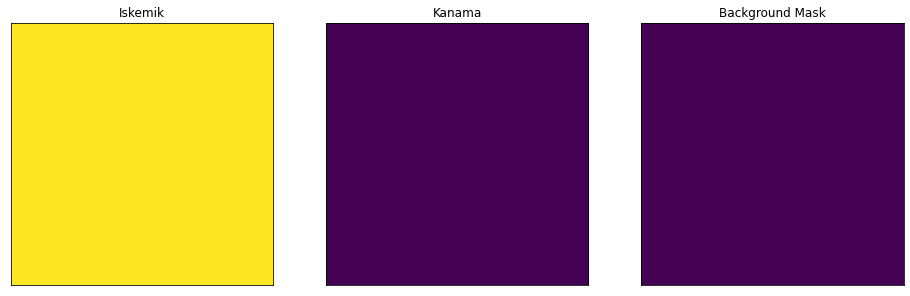

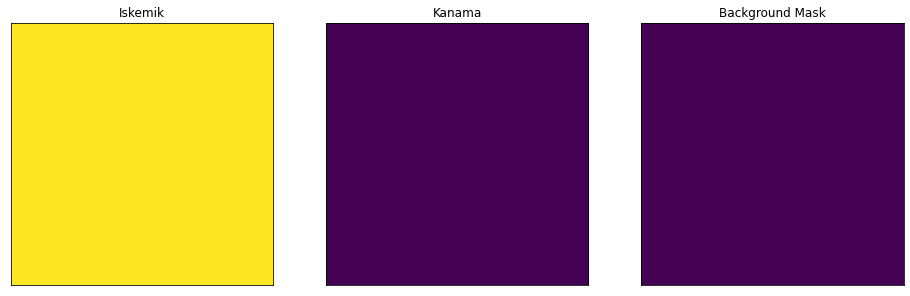

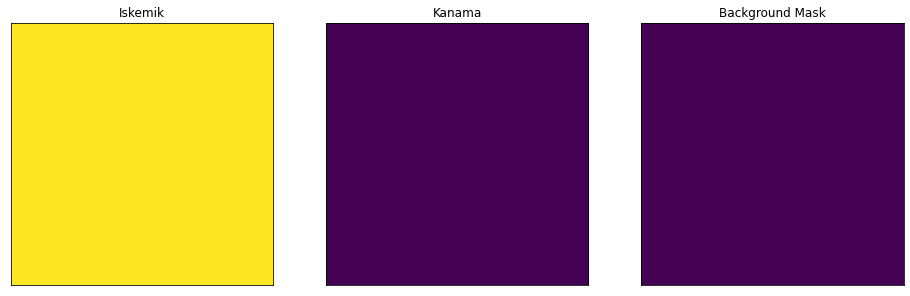

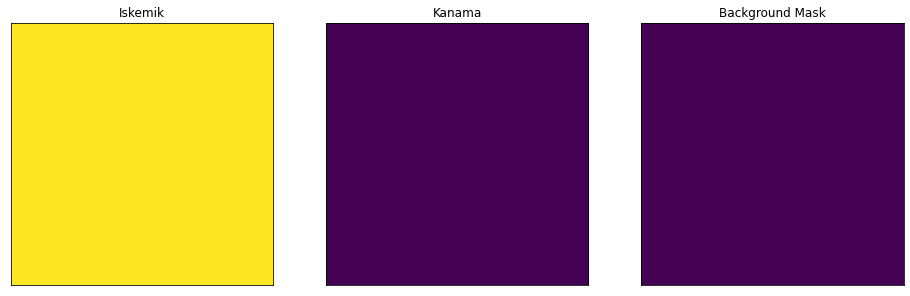

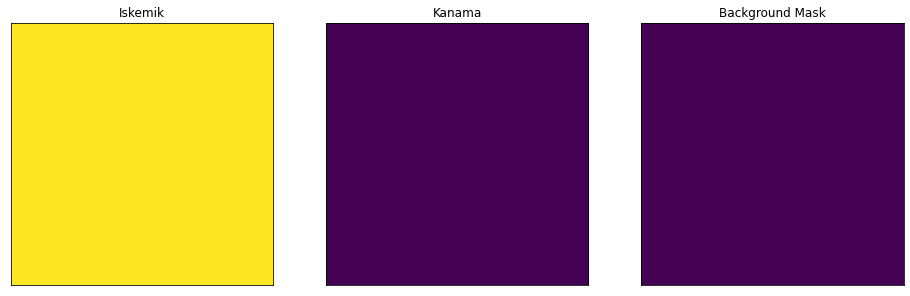

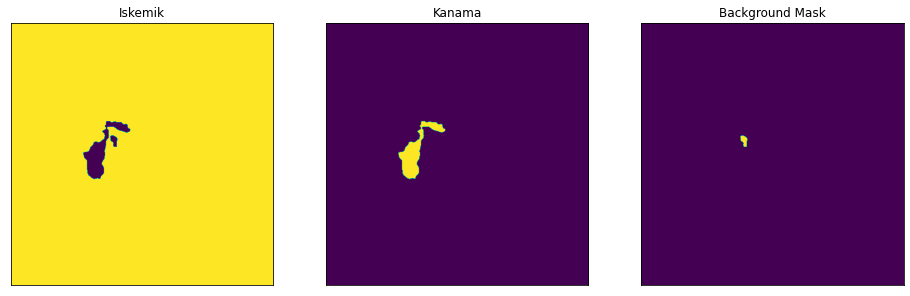

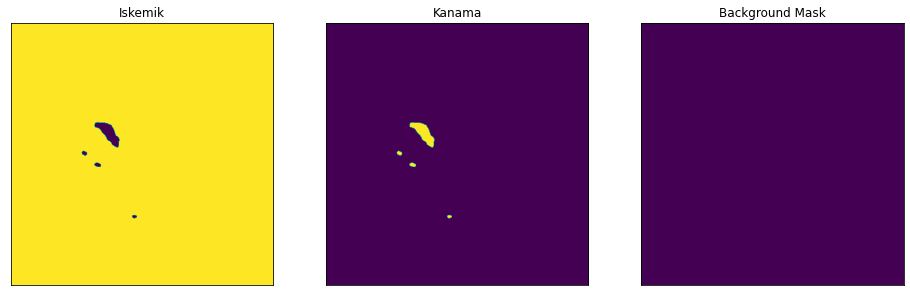

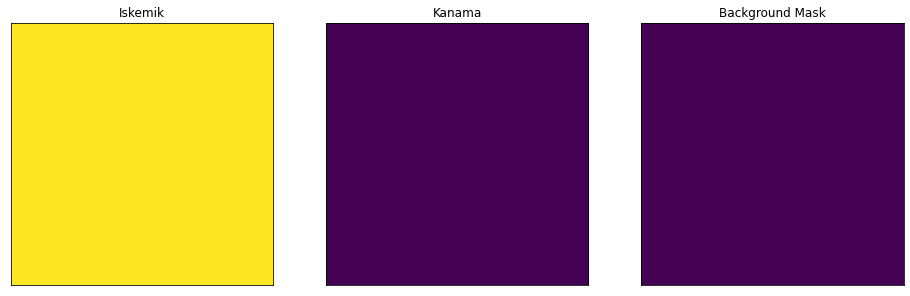

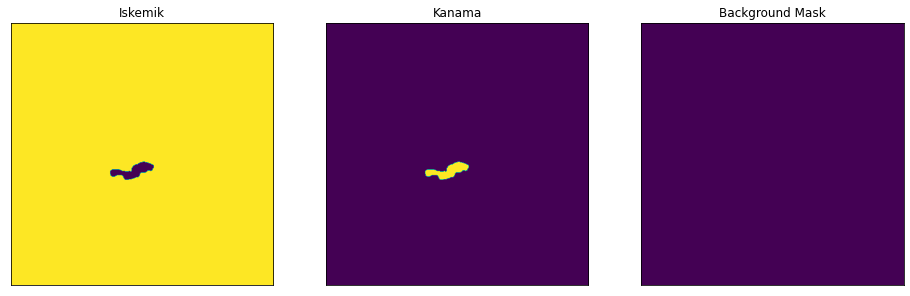

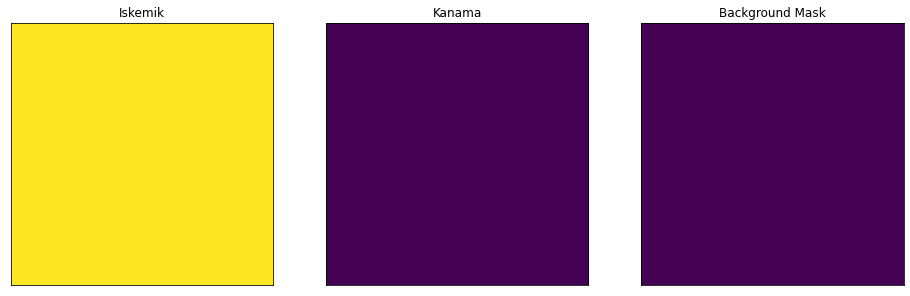

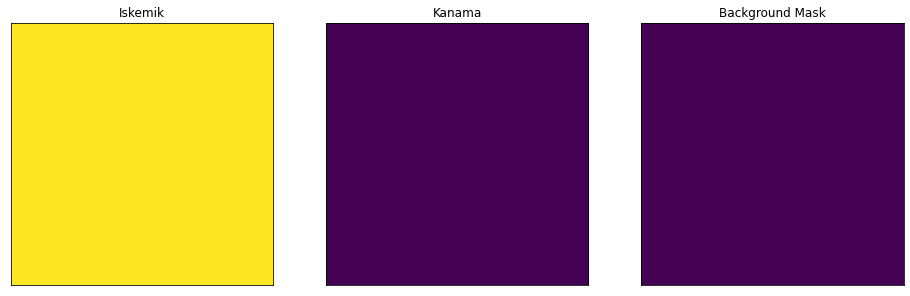

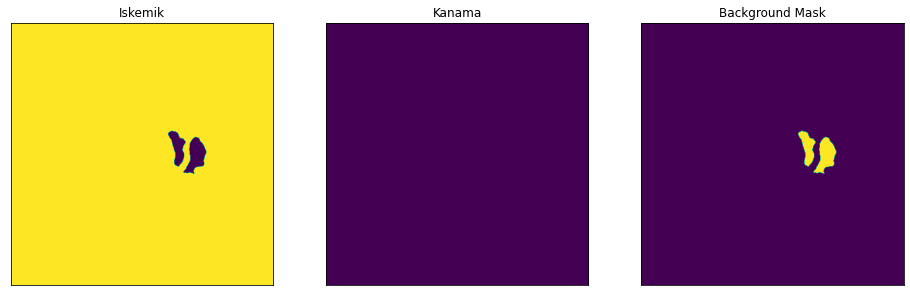

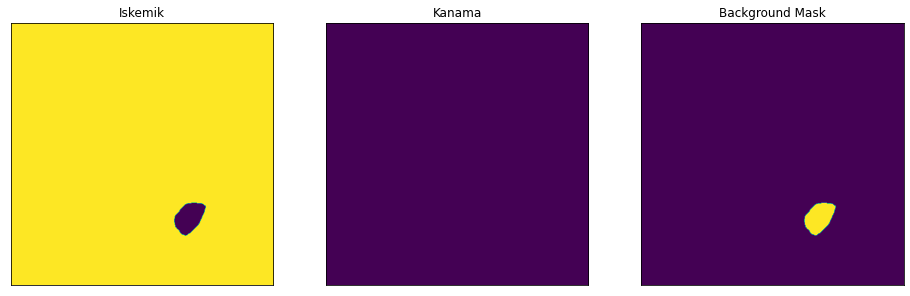

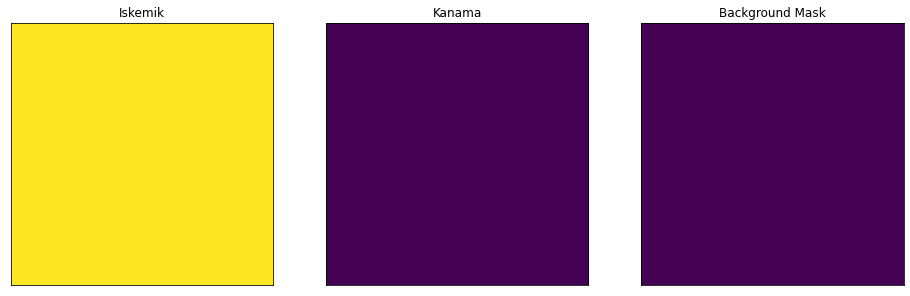

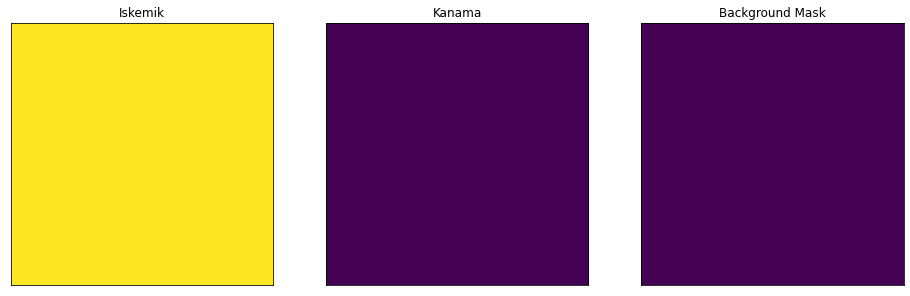

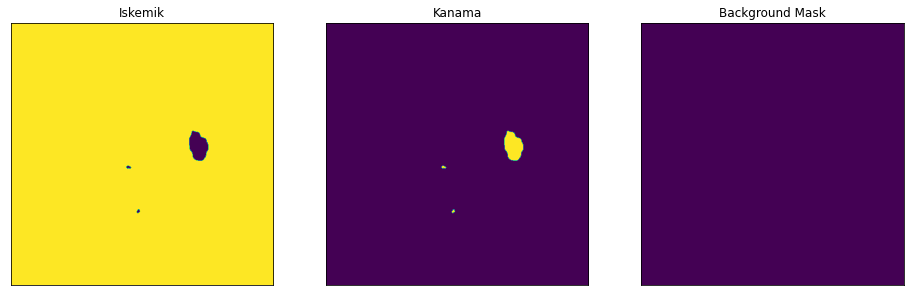

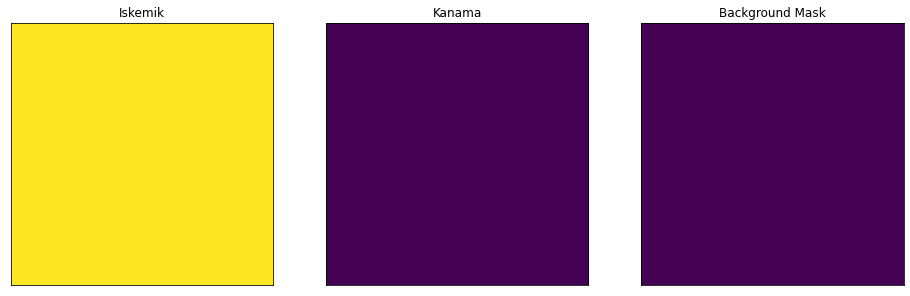

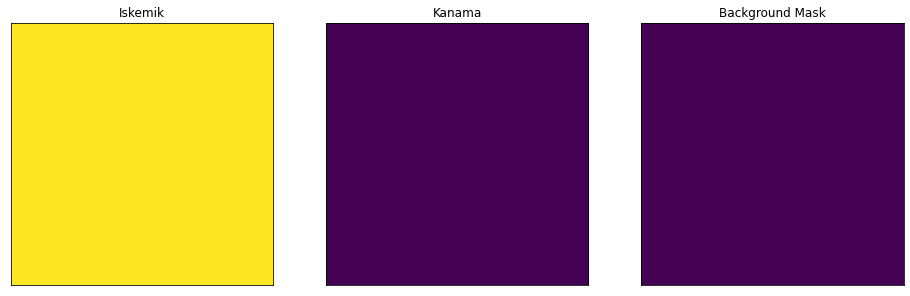

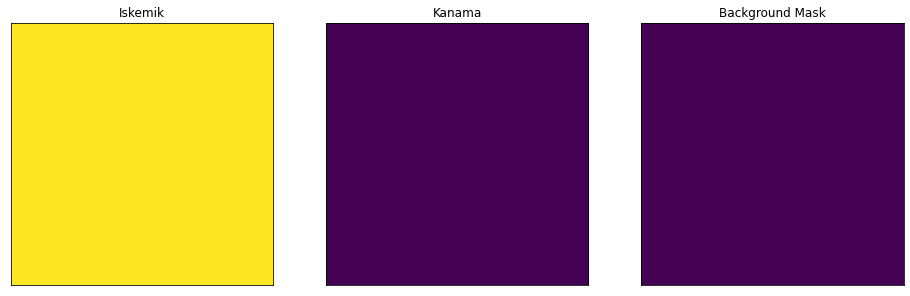

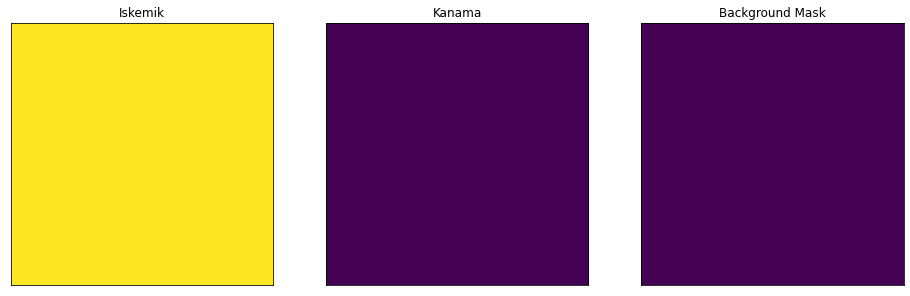

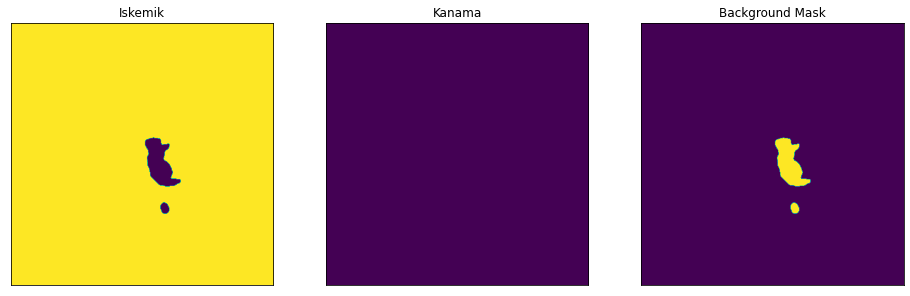

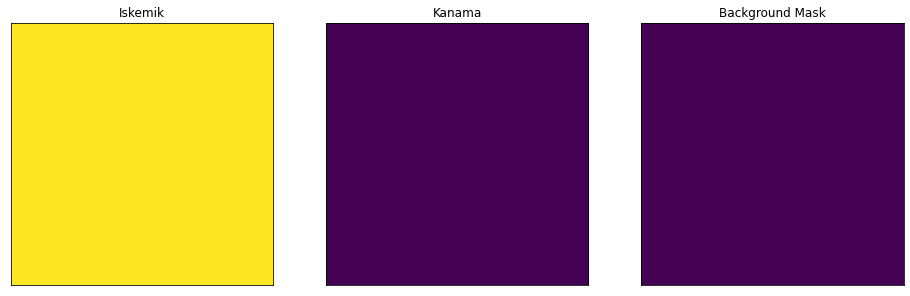

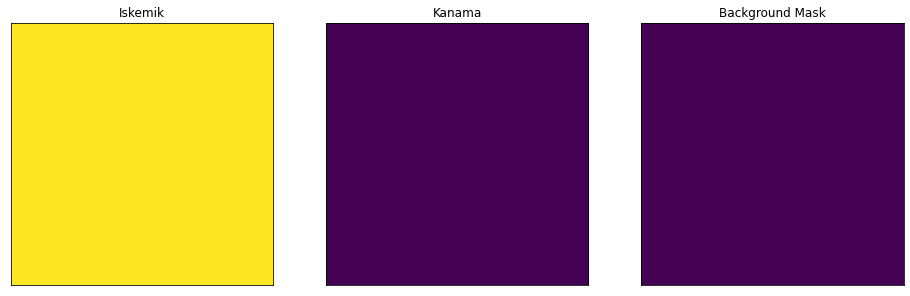

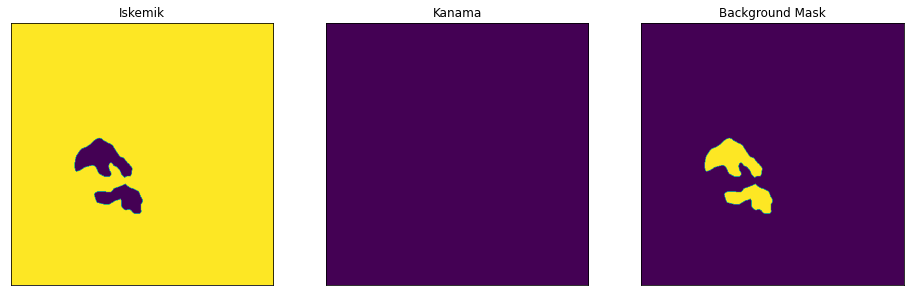

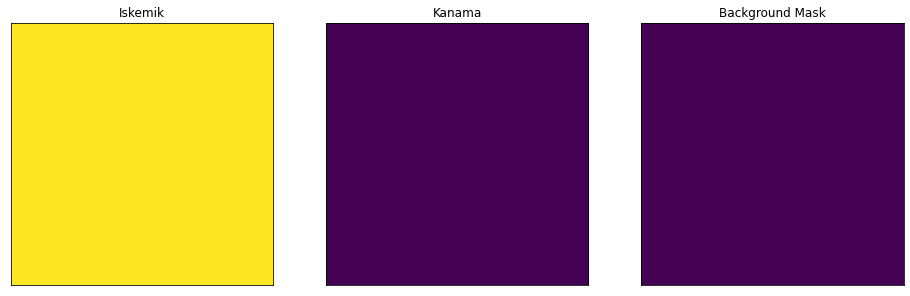

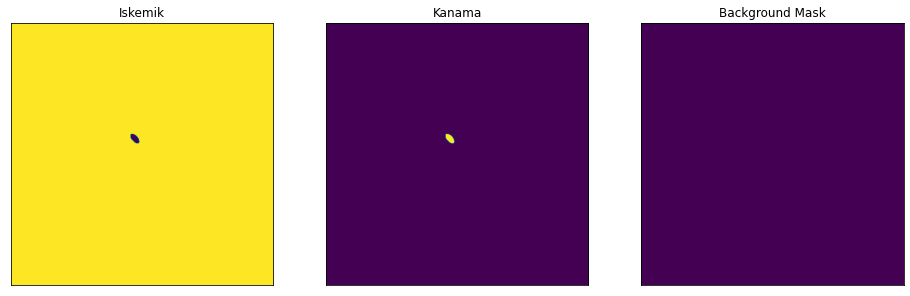

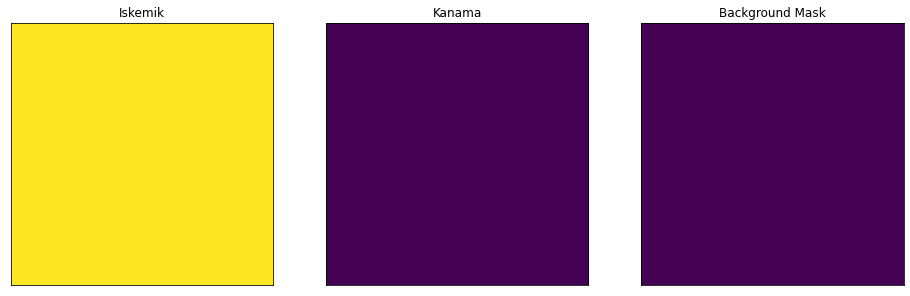

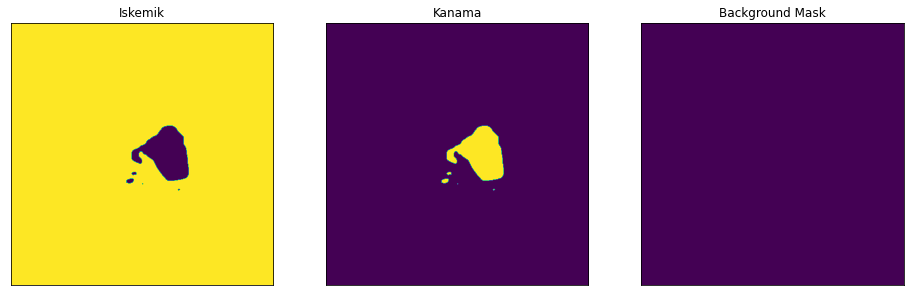

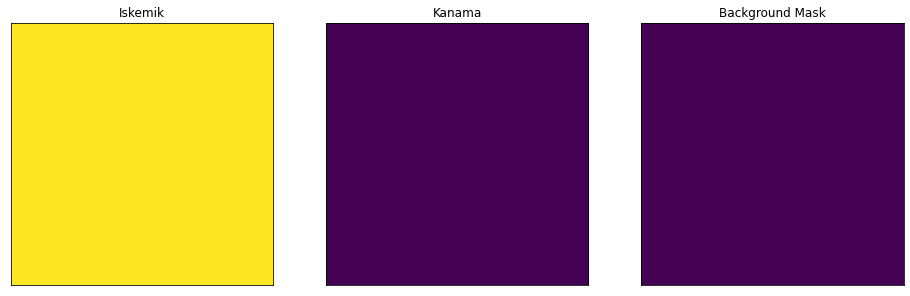

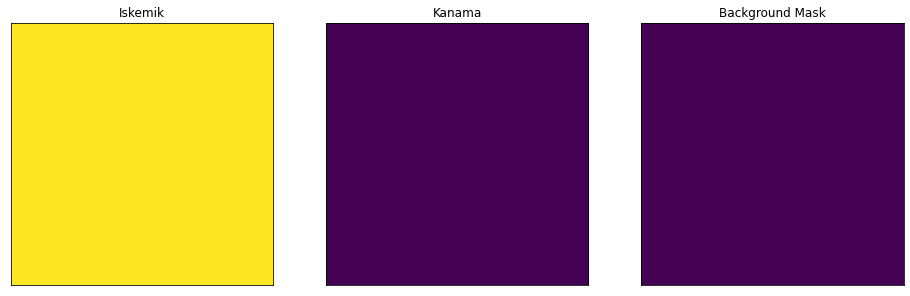

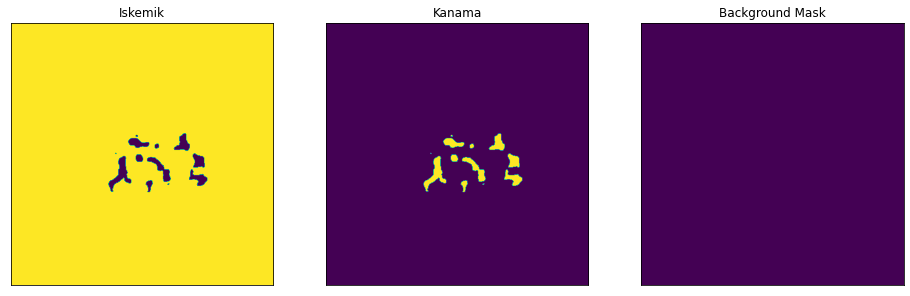

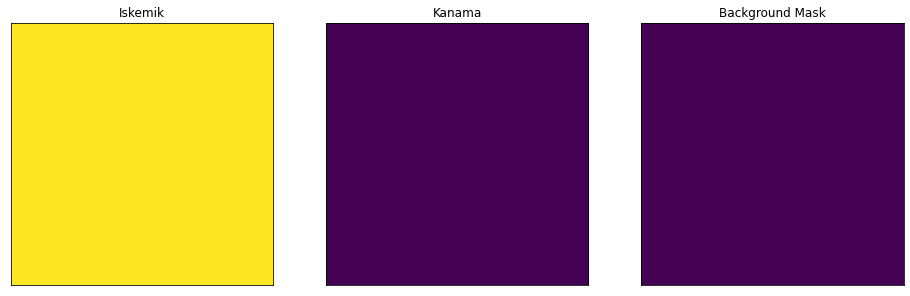

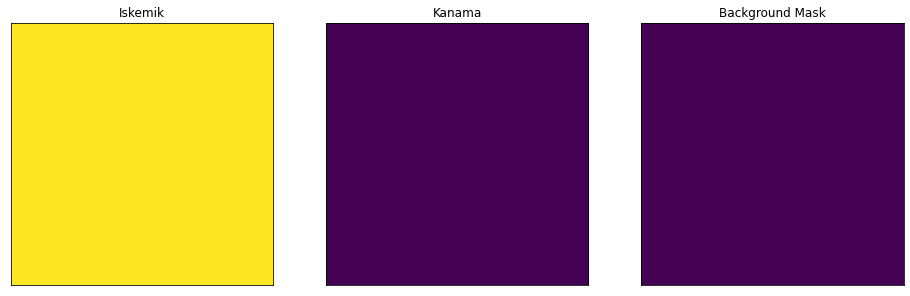

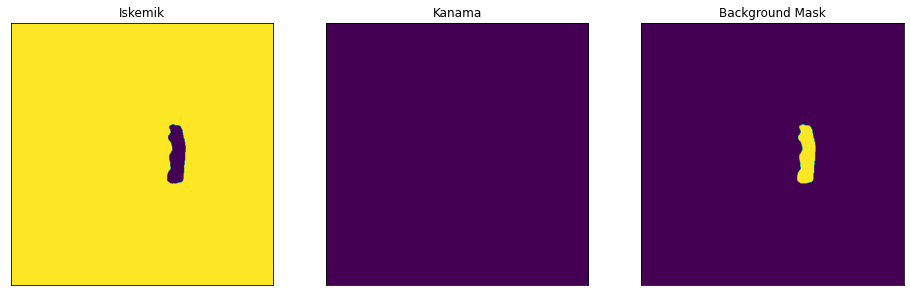

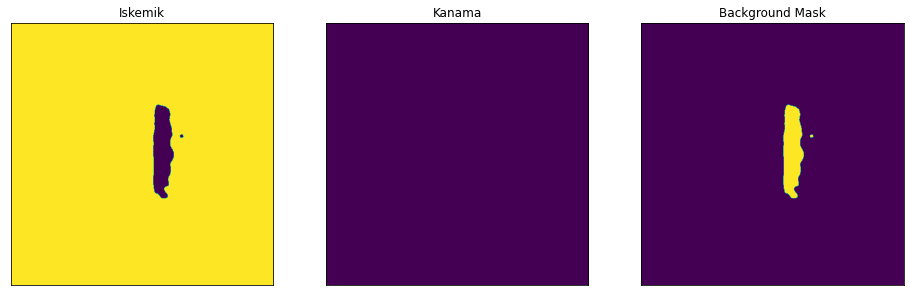

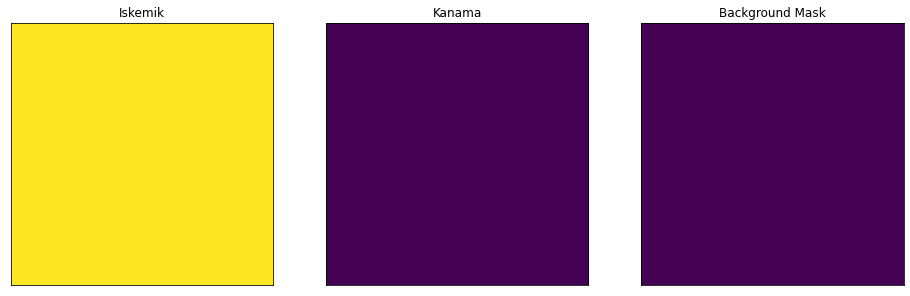

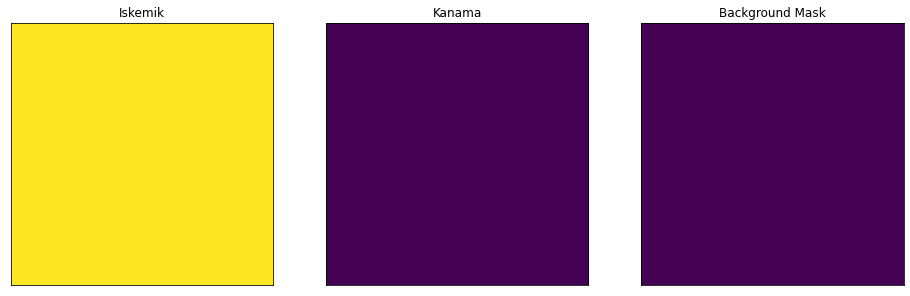

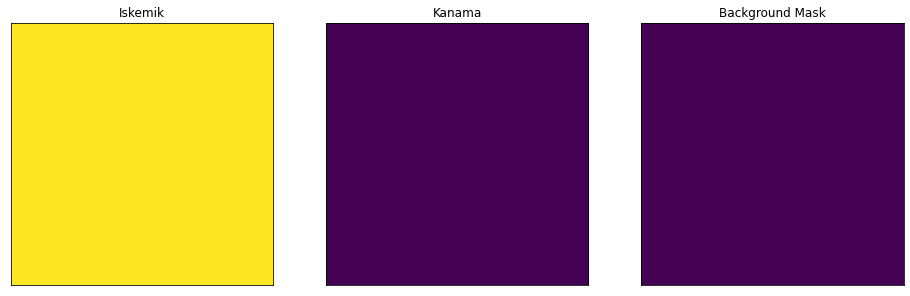

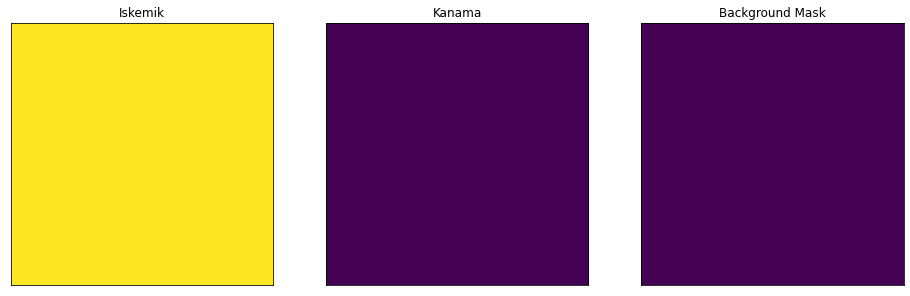

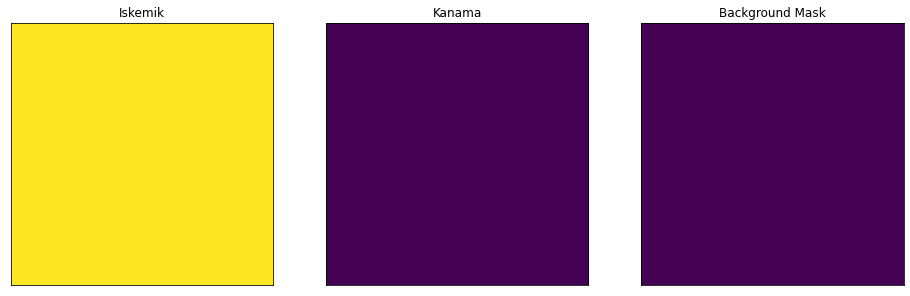

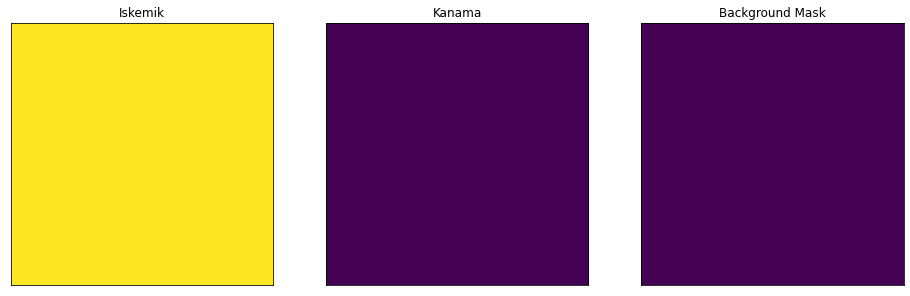

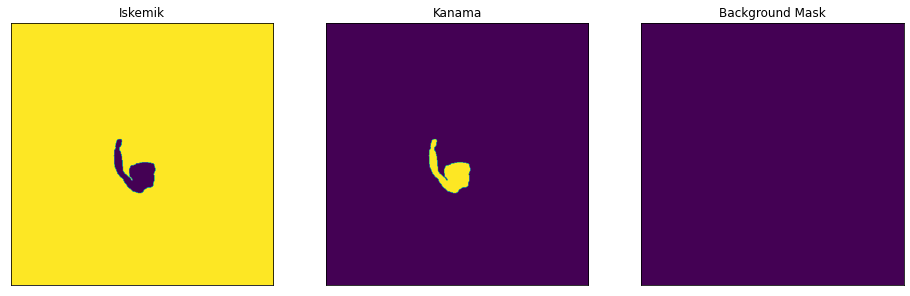

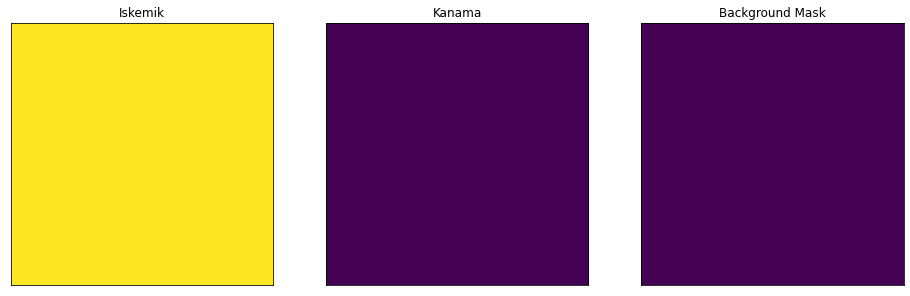

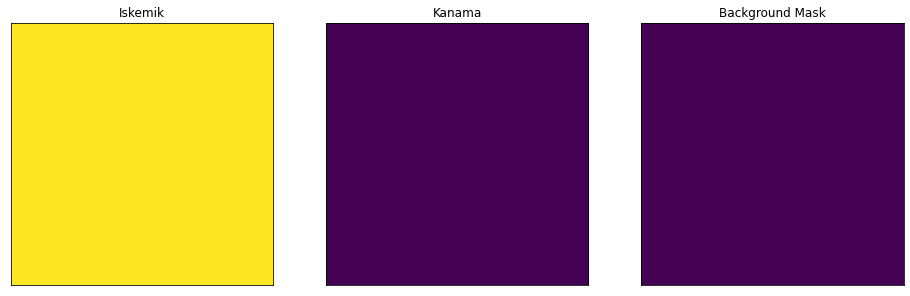

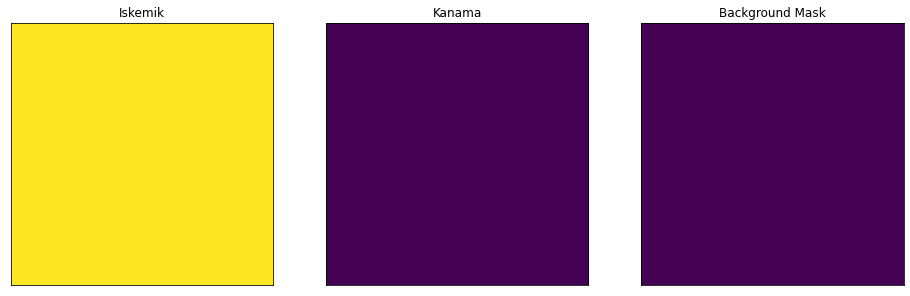

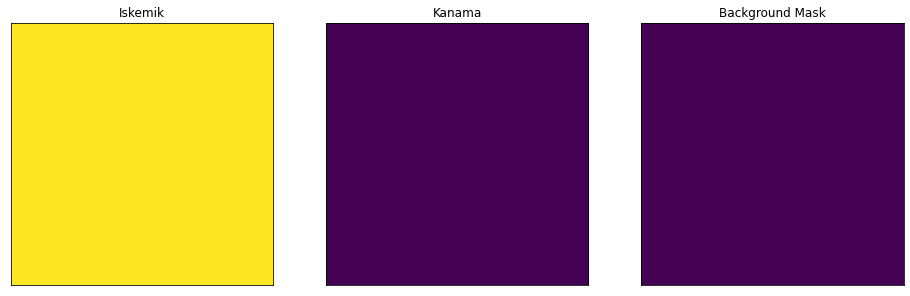

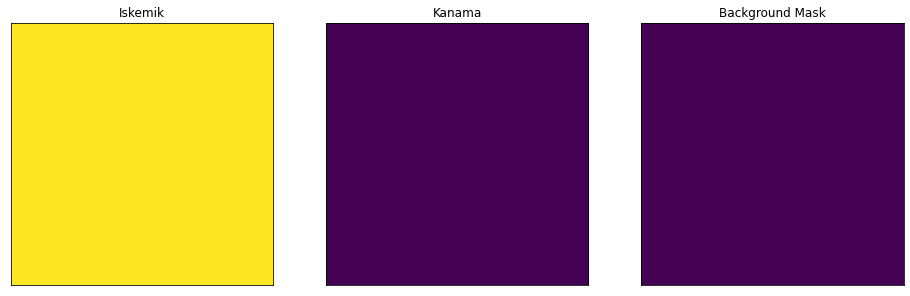

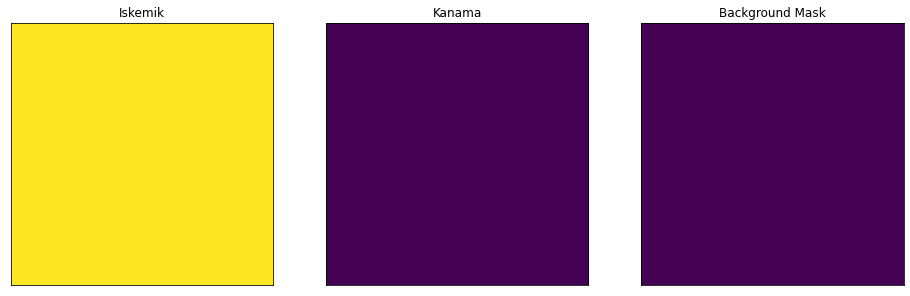

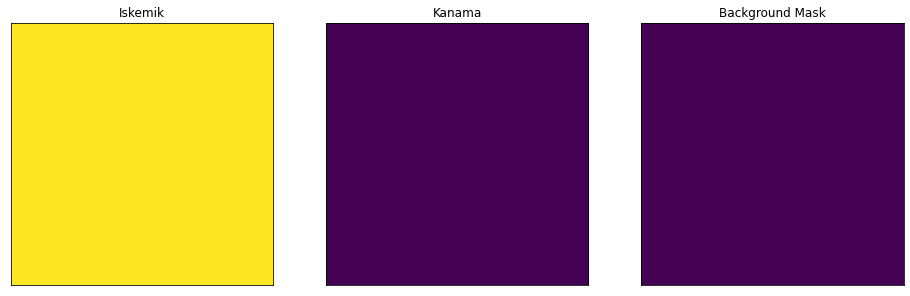

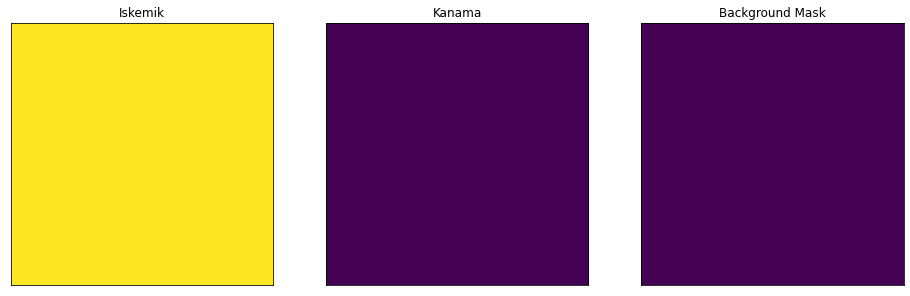

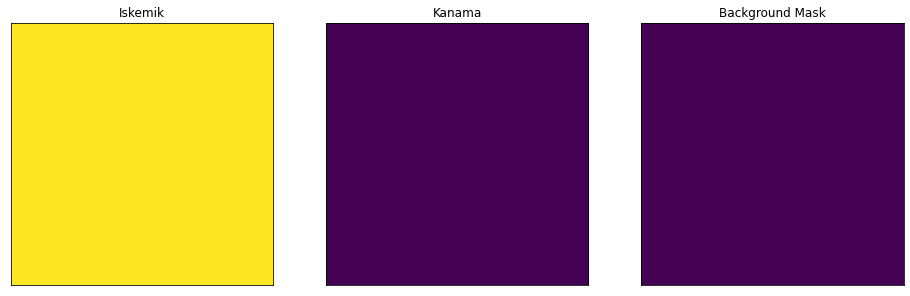

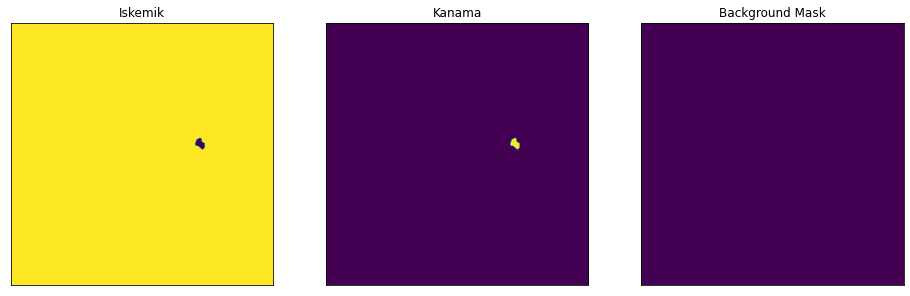

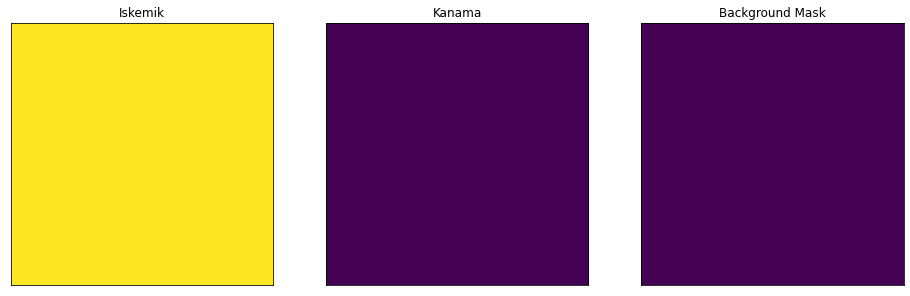

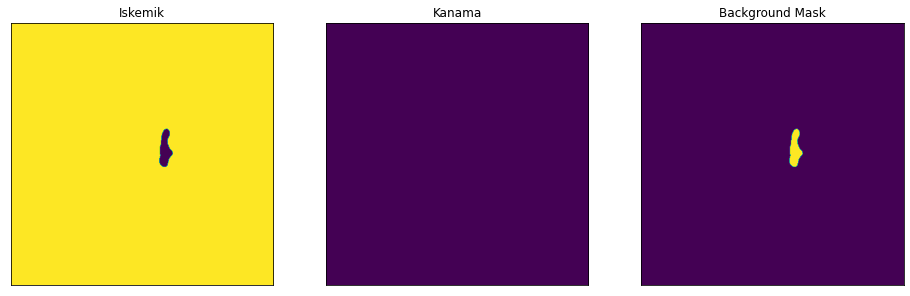

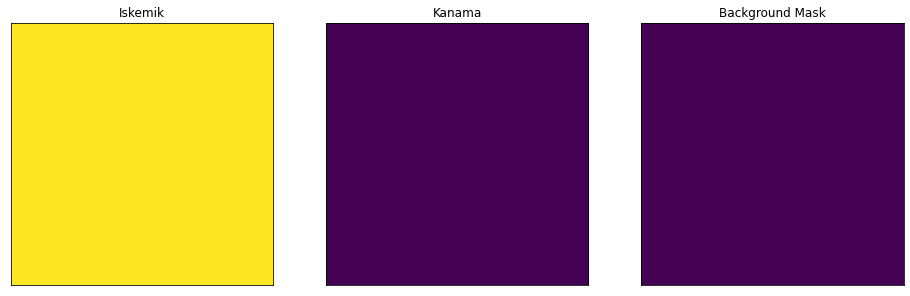

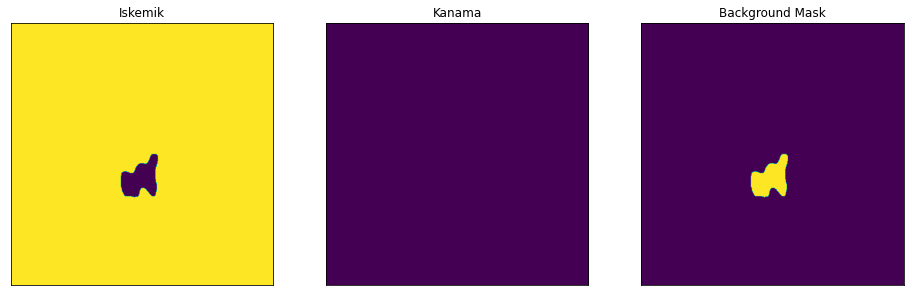

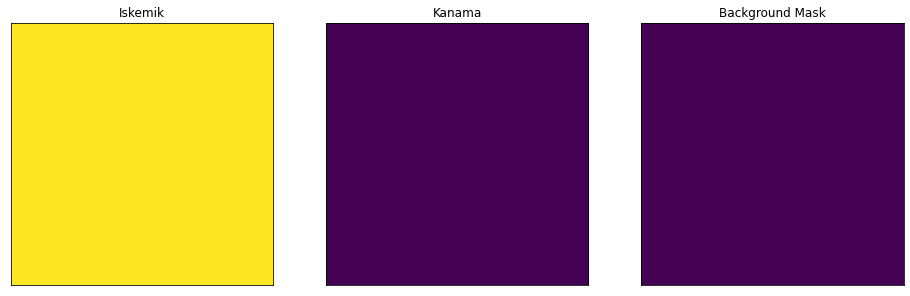

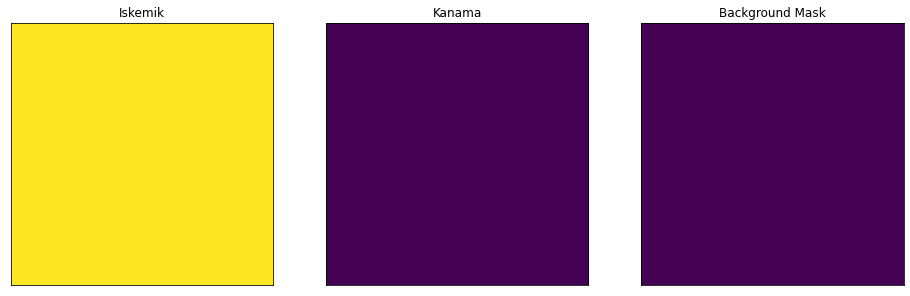

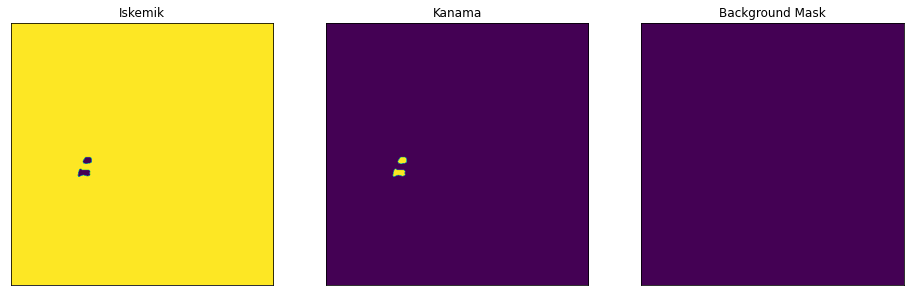

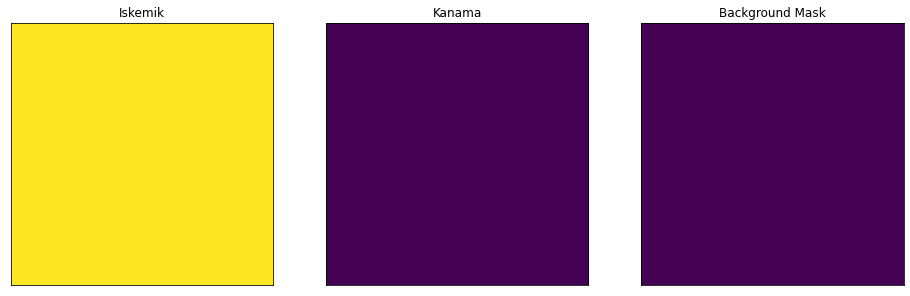

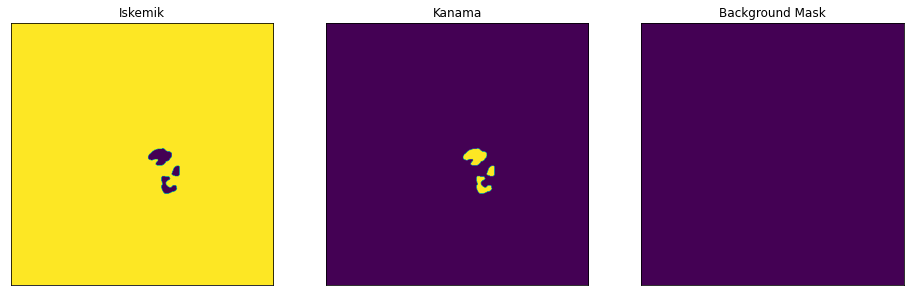

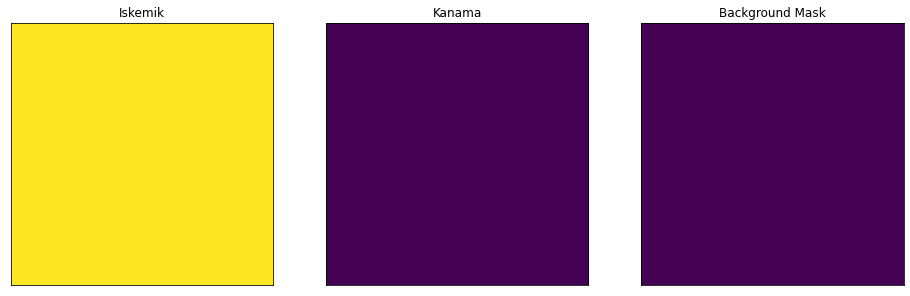

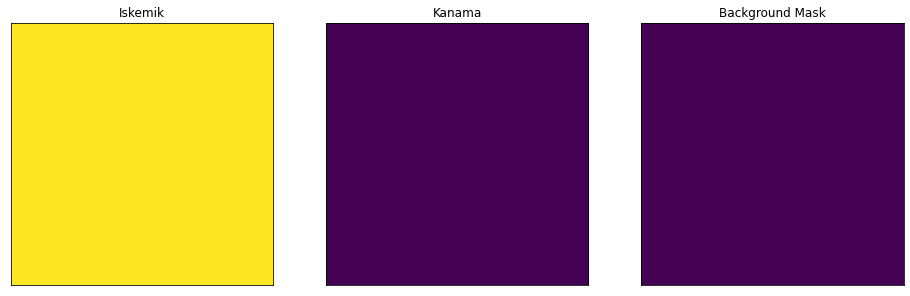

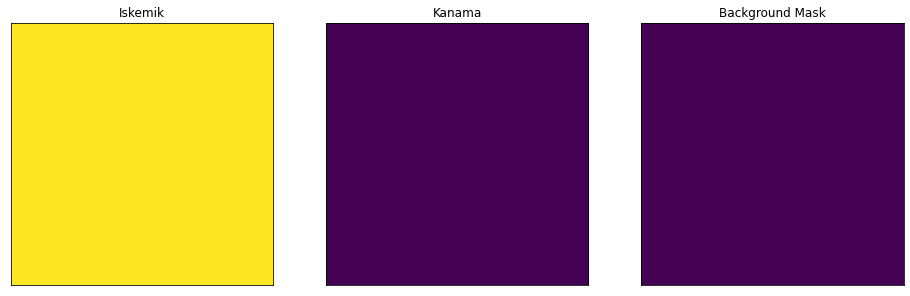

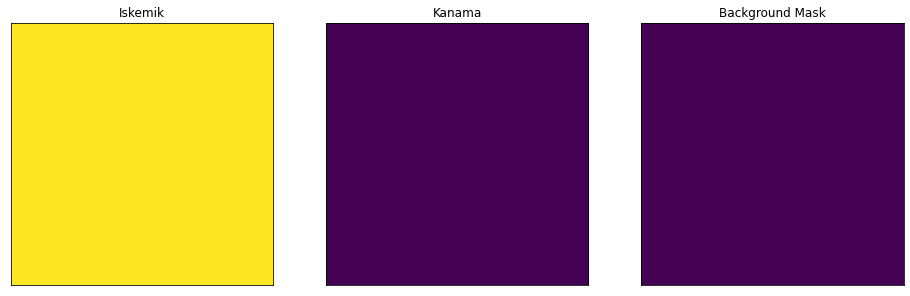

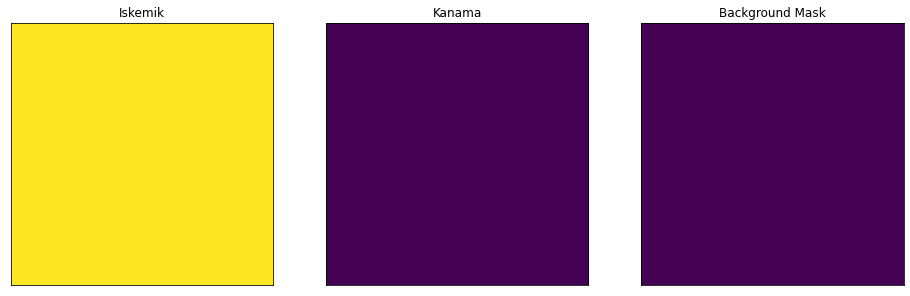

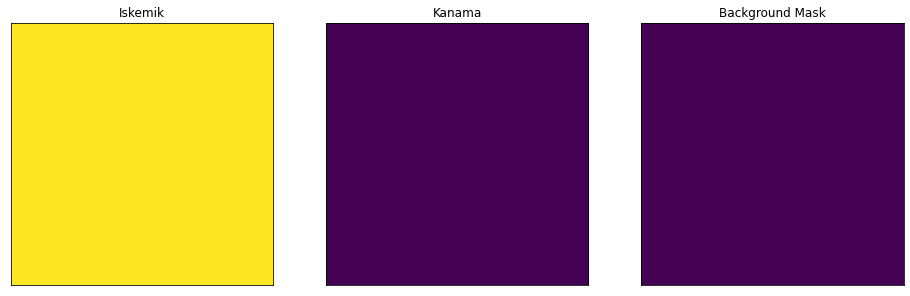

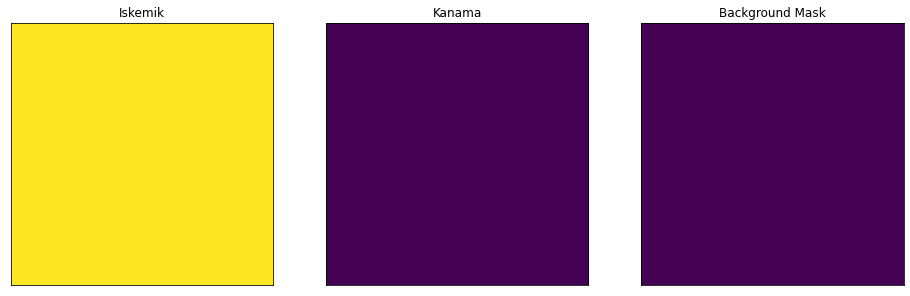

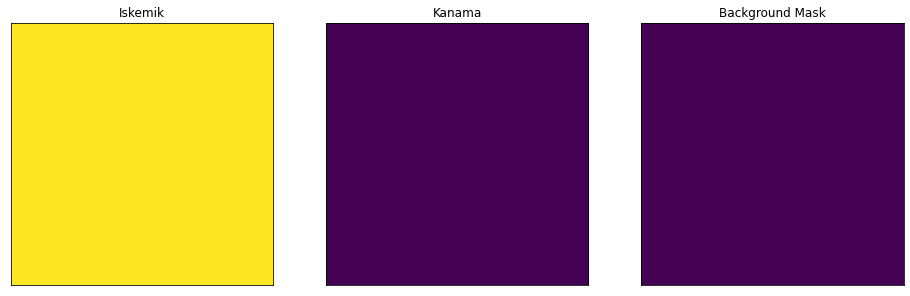

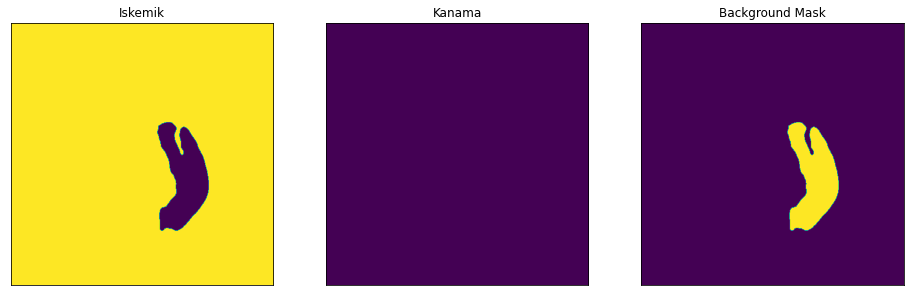

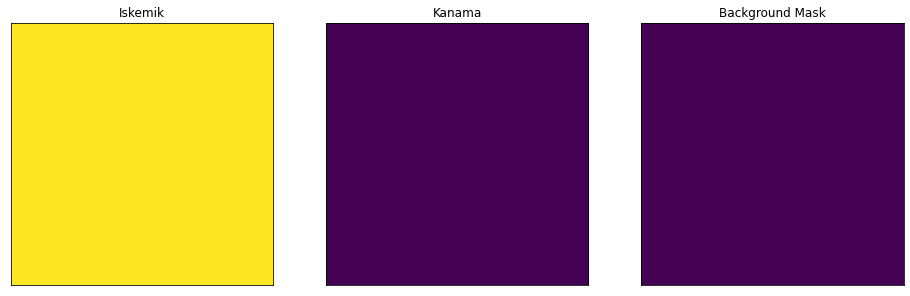

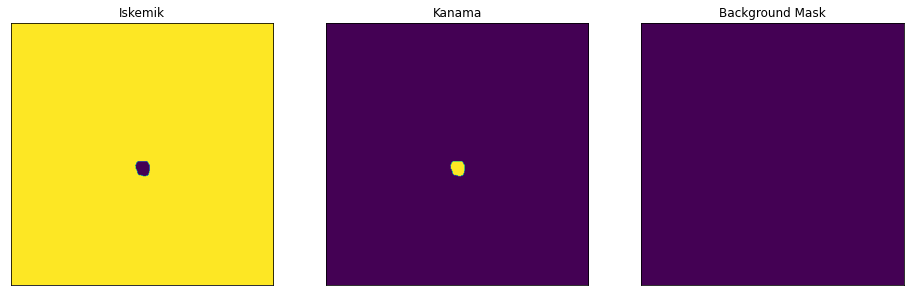

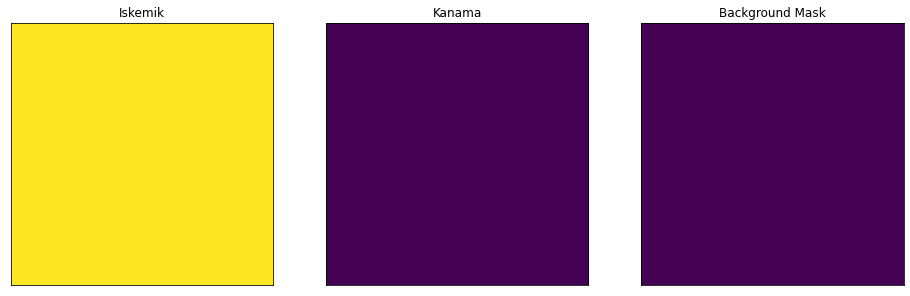

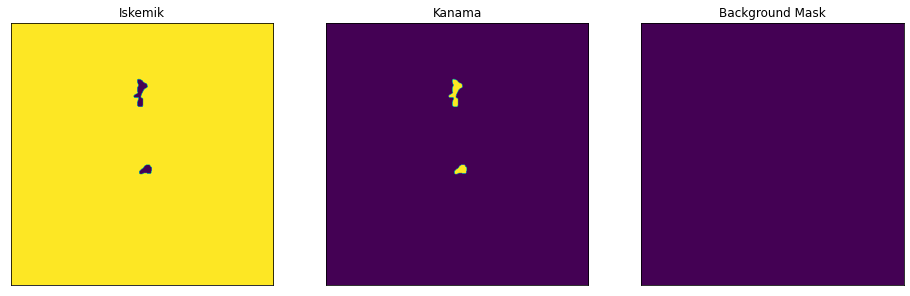

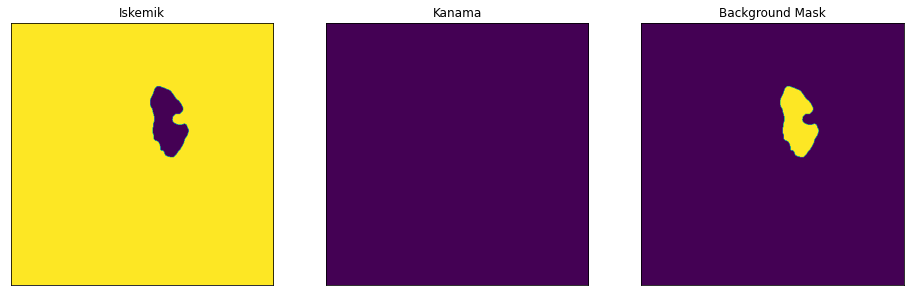

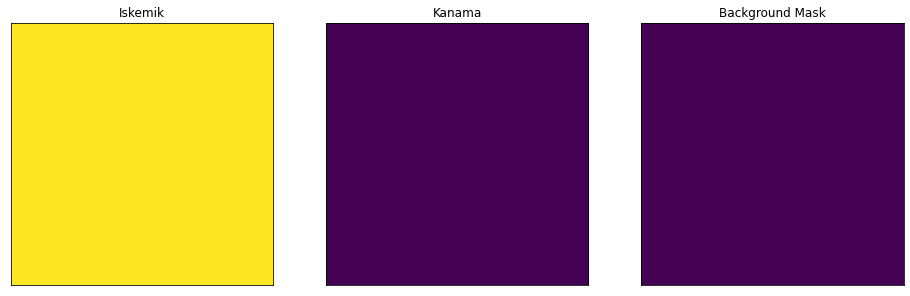

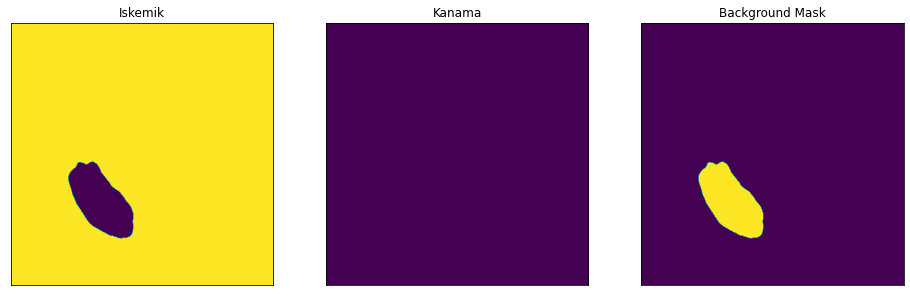

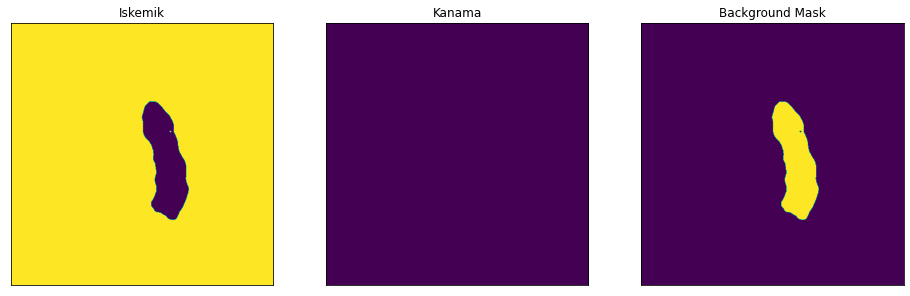

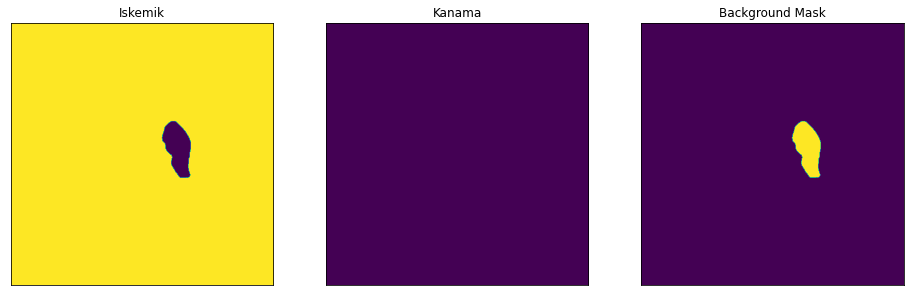

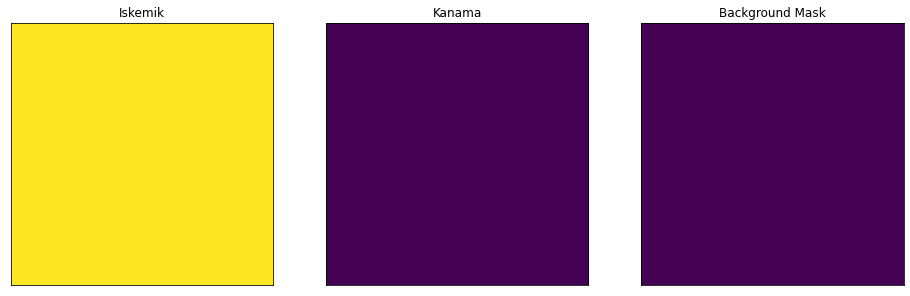

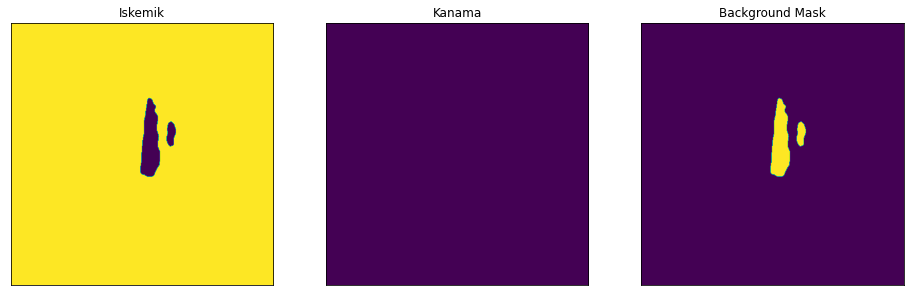

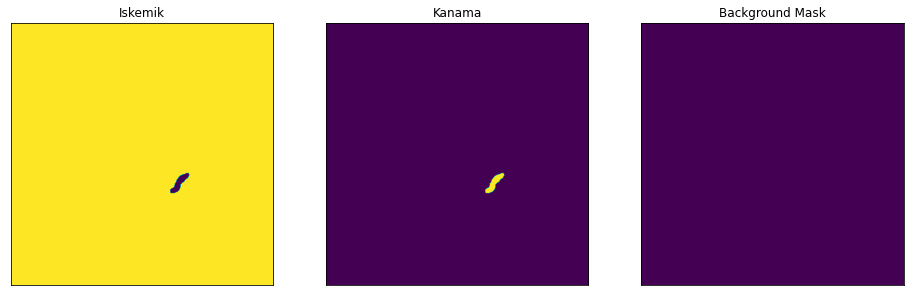

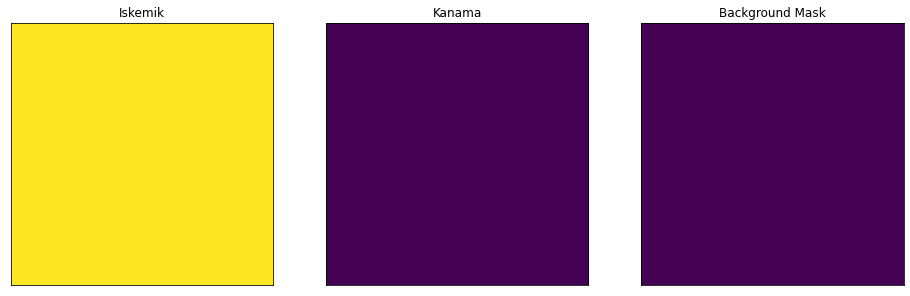

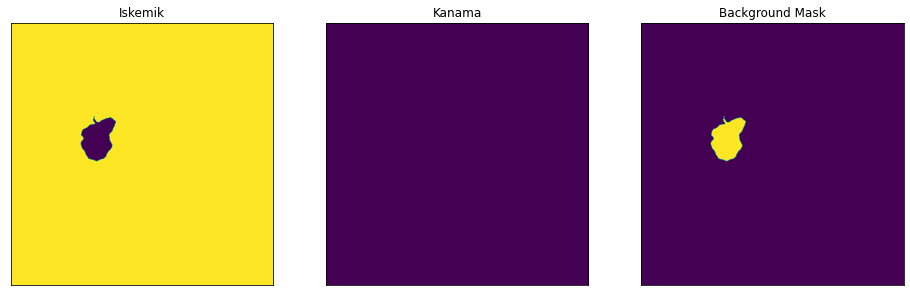

In [30]:
test_filenames = tf.io.gfile.glob(f"{save_dir}*.{IMG_EXT}")
for i in test_filenames:
    real_mask = cv2.imread(i, 0)
    
    # extract certain classes from mask (e.g. cars)
    masks = [(real_mask == v) for v in [0, 1]]
    mask = np.stack(masks, axis=-1).astype('float32')
    
    # add background if mask is not binary
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)
    
    visualize(
    iskemik=mask[..., 0].squeeze(),
    kanama=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)
    